# Importing relevant libraries

In [ ]:
#!pip install numpy pandas scikit-learn matplotlib seaborn tqdm imblearn tsaug

In [ ]:
# install cu129 torch
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

Looking in indexes: https://download.pytorch.org/whl/cu129


# Importing relevant libraries

In [3]:
from datetime import datetime
import copy
import os
import random

from imblearn.over_sampling import SMOTE
from optuna.exceptions import TrialPruned
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from tsaug import TimeWarp, Drift, AddNoise
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

c:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

GLOBAL_SEED = 0

def set_global_seed(seed=GLOBAL_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'
incart_path = 'INCART 2-lead Arrhythmia Database.csv'

mitbih_train = pd.read_csv(mitbih_train_path, header=None) # 80%
mitbih_test = pd.read_csv(mitbih_test_path, header=None)   # 20%

# Preprocessing Data

In [5]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test



In [6]:
# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [40]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()


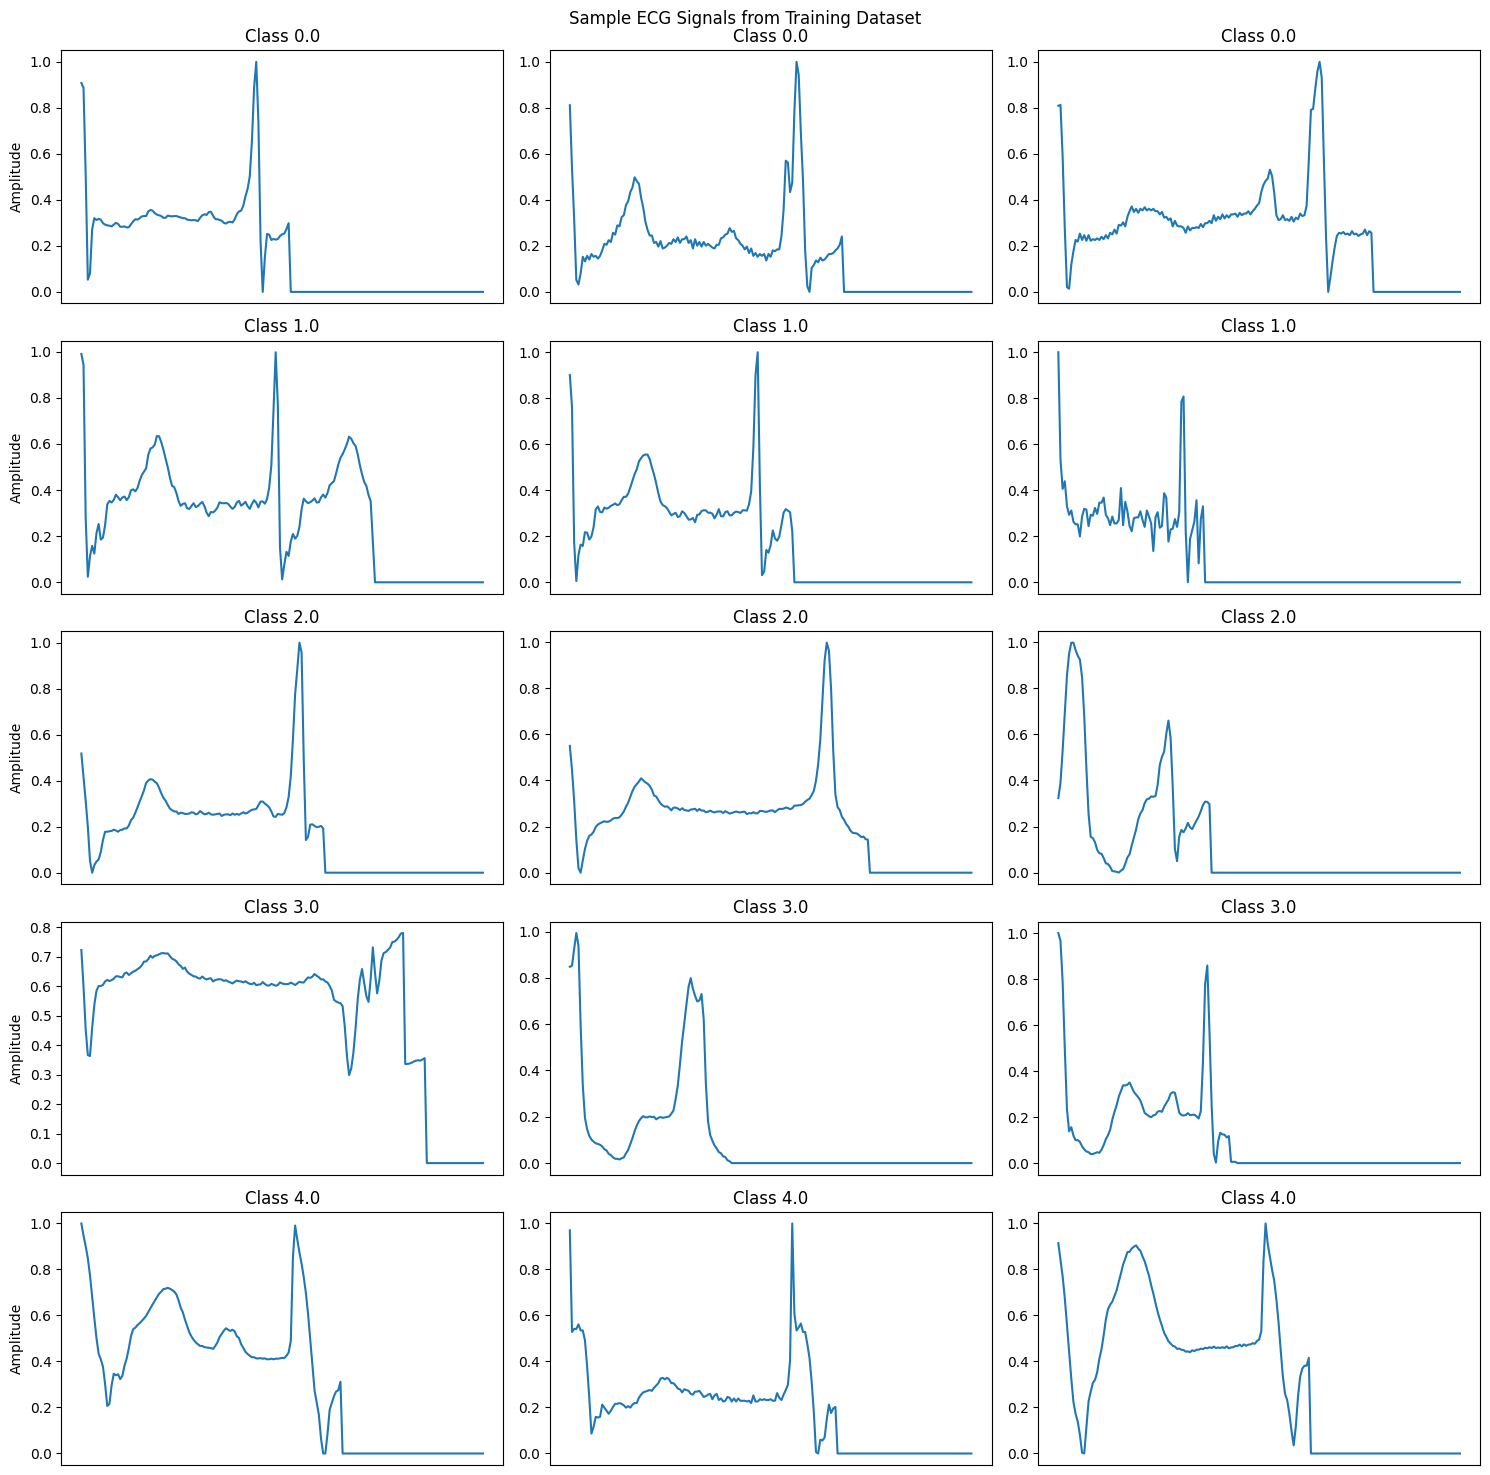


Final dataset sizes:
Training set: (85000, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [41]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# ECG Dataset on RNN Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ECG_RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_heads=4, num_classes=5, dropout=0.3):
        """
        Hierarchical Attention-Gated RNN for ECG classification.

        Args:
            input_size (int): Number of input features per timestep
            hidden_size (int): Hidden state size of RNNs
            num_layers (int): Number of RNN layers
            num_heads (int): Number of attention heads
            num_classes (int): Number of output classes
            dropout (float): Dropout rate
        """
        super(ECG_RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # --- 1. Short-term RNN ---
        self.short_rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 2. Long-term RNN ---
        self.long_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 3. Gated Residual Fusion ---
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.Sigmoid()
        )

        # --- 4. Multi-Head Attention ---
        self.attn_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            )
            for _ in range(num_heads)
        ])

        # --- 5. Context Refinement RNN ---
        self.context_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 6. Classification Head ---
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_size * 2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # --- Short-term encoding ---
        short_out, _ = self.short_rnn(x)  # (b, t, 2H)

        # --- Long-term encoding ---
        long_out, _ = self.long_rnn(short_out)  # (b, t, 2H)

        # --- Gated fusion of short- and long-term features ---
        combined = torch.cat([short_out, long_out], dim=-1)
        gate = self.gate(combined)  # (b, t, 2H)
        fused = gate * short_out + (1 - gate) * long_out  # Adaptive residual fusion

        # --- Multi-head attention ---
        attn_outputs = []
        for head in self.attn_heads:
            weights = head(fused)                # (b, t, 1)
            weights = F.softmax(weights, dim=1)  # normalize
            context = torch.sum(weights * fused, dim=1)  # (b, 2H)
            attn_outputs.append(context)

        # Concatenate multiple attention heads
        multihead_context = torch.stack(attn_outputs, dim=1)  # (b, heads, 2H)

        # --- Context refinement RNN ---
        refined, _ = self.context_rnn(multihead_context)  # (b, heads, 2H)
        refined = torch.mean(refined, dim=1)              # global fusion

        # --- Classification ---
        out = self.fc(refined)
        return out



In [10]:
# New: SE block and Conv+BiGRU+Attention model
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        hidden = max(1, channels // reduction)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x: (B, C, T)
        w = x.mean(dim=-1)             # (B, C)
        w = self.fc(w)                 # (B, C)
        w = w.unsqueeze(-1)            # (B, C, 1)
        return x * w                   # scale

class ECG_ConvBiGRU_Attn(nn.Module):
    def __init__(self, input_size=1, num_classes=5, conv_channels=64, gru_hidden=128, num_gru_layers=2, dropout=0.3):
        super().__init__()
        C = conv_channels
        # 1D Conv frontend with multi-dilation to capture morphology
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, C, kernel_size=7, padding=3, dilation=1),
            nn.BatchNorm1d(C),
            nn.ReLU(inplace=True),
        )
        self.se1 = SEBlock(C)

        self.conv2 = nn.Sequential(
            nn.Conv1d(C, 2*C, kernel_size=5, padding=4, dilation=2),
            nn.BatchNorm1d(2*C),
            nn.ReLU(inplace=True),
        )
        self.se2 = SEBlock(2*C)

        # BiGRU backbone
        self.bigru = nn.GRU(
            input_size=2*C,
            hidden_size=gru_hidden,
            num_layers=num_gru_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Attention pooling over time
        self.attn = nn.Sequential(
            nn.Linear(2*gru_hidden, gru_hidden),
            nn.Tanh(),
            nn.Linear(gru_hidden, 1)
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.LayerNorm(2*gru_hidden),
            nn.Linear(2*gru_hidden, gru_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(gru_hidden, num_classes),
        )

    def forward(self, x):
        # x: (B, T, 1)
        x = x.transpose(1, 2)          # (B, 1, T)
        x = self.conv1(x)              # (B, C, T)
        x = self.se1(x)
        x = self.conv2(x)              # (B, 2C, T)
        x = self.se2(x)
        x = x.transpose(1, 2)          # (B, T, 2C)

        # BiGRU
        h, _ = self.bigru(x)           # (B, T, 2H)

        # Attention pooling
        w = self.attn(h)               # (B, T, 1)
        w = F.softmax(w, dim=1)        # (B, T, 1)
        ctx = (w * h).sum(dim=1)       # (B, 2H)

        # Classifier
        out = self.fc(ctx)             # (B, num_classes)
        return out

## Alternative RNN: Conv + BiGRU + Attention

 Motivation:
 - Local morphological features (QRS complexes, ST segments) benefit from 1D convolutions capturing short-term patterns at multiple receptive fields.
 - GRUs often match LSTMs with fewer parameters on physiological time-series (useful for efficiency and regularization on MIT-BIH).
 - Squeeze-and-Excitation (SE) channel attention (Hu et al., 2018) improves representational power by recalibrating feature maps.
 - Attention pooling highlights salient timesteps for classification (commonly adopted in ECG literature: attention BiRNNs for arrhythmia detection).

 Architecture:
   Conv1D(1->C, k=7, dilations) + SE -> Conv1D(C->2C, k=5, dilations) + SE -> BiGRU(hidden=H, layers=L) -> Attn Pool -> FC.

 References:
 - Hu et al., "Squeeze-and-Excitation Networks", CVPR 2018.
 - Yildirim (2018)/and subsequent works: attention with BiRNNs for ECG arrhythmia classification.
 - Empirical results across time-series show CNN+RNN hybrids outperform single-stage models by combining local+long-range dependencies.

In [11]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing
        # weight: tensor/array of shape (C,) or None
        self.register_buffer('weight', None)
        if weight is not None:
            self.register_buffer('weight', torch.as_tensor(weight, dtype=torch.float))

    def forward(self, pred, target):
        """
        pred: (B, C), target: (B,) class indices
        Applies label smoothing and optional class weights (like nn.CrossEntropyLoss).
        """
        log_probs = F.log_softmax(pred, dim=1)
        n_classes = pred.size(1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.scatter_(1, target.unsqueeze(1), 1)
            true_dist = true_dist * (1 - self.smoothing) + self.smoothing / n_classes
        per_sample = -(true_dist * log_probs).sum(dim=1)  # (B,)
        if self.weight is not None:
            sample_w = self.weight[target]
            loss = (per_sample * sample_w).sum() / sample_w.sum()
        else:
            loss = per_sample.mean()
        return loss

In [33]:
def get_training_config():
    """
    Returns improved training configuration for RNN and ConvBiGRU models
    """
    config = {
        'RNN': {
            'model_params': {
                'input_size': 1,
                'hidden_size': 128,
                'num_layers': 2,
                'num_classes': 5,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 1e-3,
                'batch_size': 64,
                'num_epochs': 50,
                'warmup_epochs': 3,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 1.5,
                'early_stopping': {  # new
                    'patience': 10,
                    'min_delta': 1e-3,
                    'restore_best': True
                }
            },
        },
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 1.5e-3,
                'batch_size': 64,
                'num_epochs': 50,
                'warmup_epochs': 3,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 1.5,
                'early_stopping': {  # new
                    'patience': 10,
                    'min_delta': 1e-3,
                    'restore_best': True
                }
            },
        },
        'ConvBiGRU': {  # new model
            'model_params': {
                'input_size': 1,
                'num_classes': 5,
                'conv_channels': 64,
                'gru_hidden': 128,
                'num_gru_layers': 2,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 1.5e-3,
                'batch_size': 64,
                'num_epochs': 50,
                'warmup_epochs': 3,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 1.5,
                'early_stopping': {
                    'patience': 10,
                    'min_delta': 1e-4,
                    'restore_best': True
                }
            }
        }
    }
    return config

In [34]:
# Initialize RNN model
rnn_model = ECG_RNN(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=5,
    dropout=0.3
)

# Get recommended training configurations
config = get_training_config()

In [35]:
class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config):
        from copy import deepcopy
        from torch.optim.swa_utils import AveragedModel
        self._deepcopy = deepcopy  # store reference for later use without re-import

        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Scheduler config (created in train when train_loader is known)
        self.scheduler = None
        self.scheduler_type = config.get('scheduler', 'custom')

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')

        # Early stopping setup
        es_cfg = config.get('early_stopping', {})
        self.es_patience = int(es_cfg.get('patience', 10))
        self.es_min_delta = float(es_cfg.get('min_delta', 0.0))
        self.es_restore_best = bool(es_cfg.get('restore_best', True))
        self.es_no_improve = 0
        self.best_state_dict = None

        # Fine-tuning additions
        self.grad_accum_steps = int(config.get('grad_accum_steps', 1))
        self.mixed_precision = bool(config.get('mixed_precision', False)) and torch.cuda.is_available()
        self.mixup_alpha = float(config.get('mixup_alpha', 0.0))
        self.use_swa = bool(config.get('use_swa', False))
        self.swa_start_fraction = float(config.get('swa_start', 0.8))
        self.swa_eval = bool(config.get('swa_eval', True))
        self.swa_model = None  # AveragedModel when enabled

        # AMP scaler
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def _build_scheduler(self, train_loader_len):
            total_steps = len(train_loader) * self.config['num_epochs']
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
                self.optimizer,
                max_lr=self.config['max_lr'],        # e.g., 1e-3
                total_steps=total_steps,
                pct_start=0.1,                        # 10% warmup
                div_factor=10,                         # initial_lr = max_lr / div_factor
                final_div_factor=100.0,                # final_lr = max_lr / final_div_factor
                anneal_strategy='cos',                 # cosine annealing
            )

    def _mixup(self, x, y):
        if self.mixup_alpha <= 0:
            return x, y, None, None, 1.0
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        index = torch.randperm(x.size(0), device=x.device)
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, index, lam

    def train_epoch(self, train_loader, epoch, total_epochs):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        steps = 0

        for step, (batch_X, batch_y) in enumerate(tqdm(train_loader, desc='Training')):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            # Mixup (if enabled)
            inputs, targets_a, targets_b, index, lam = self._mixup(batch_X, batch_y)

            with torch.cuda.amp.autocast(enabled=self.mixed_precision):
                result = self.model(inputs)
                outputs = result[0] if isinstance(result, (tuple, list)) else result
                if targets_b is None:
                    loss = self.criterion(outputs, batch_y)
                else:
                    loss = lam * self.criterion(outputs, targets_a) + (1 - lam) * self.criterion(outputs, targets_b)

            # Gradient scaling/accumulation
            self.scaler.scale(loss / self.grad_accum_steps).backward()

            if (step + 1) % self.grad_accum_steps == 0:
                # Gradient clipping
                if self.config.get('gradient_clip_val', None) is not None:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.config['gradient_clip_val'])
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                # Scheduler per-step for OneCycle
                if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    try:
                        self.scheduler.step()
                    except Exception:
                        pass

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            steps += 1

        epoch_loss = total_loss / max(1, steps)
        epoch_acc = 100 * correct / max(1, total)
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        steps = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                steps += 1

        epoch_loss = total_loss / max(1, steps)
        epoch_acc = 100 * correct / max(1, total)
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs, epoch_callback=None):
        """Complete training process with early stopping + HPO callback support"""
        print(f"\nStarting training for {self.model_name}...")
        if self.scheduler is None:
            self._build_scheduler(len(train_loader))

        swa_begin_epoch = int(np.floor(self.swa_start_fraction * num_epochs)) if self.use_swa else None

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader, epoch, num_epochs)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            if isinstance(self.scheduler, torch.optim.lr_scheduler._LRScheduler):
                current_lr = self.scheduler.step()
            else:
                current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Optional epoch callback (for Optuna pruning)
            if epoch_callback is not None:
                epoch_callback(epoch, train_loss, val_loss, train_acc, val_acc, current_lr)

            # Early stopping check with best model saving
            if val_loss < self.best_val_loss - self.es_min_delta:
                self.best_val_loss = val_loss
                self.es_no_improve = 0
                self.best_state_dict = self._deepcopy(self.model.state_dict())
                self.save_model('best_model.pth')
                print(f'New best model saved! (Val Loss: {val_loss:.4f})')
            else:
                self.es_no_improve += 1
                print(f'No improvement: {self.es_no_improve}/{self.es_patience}')

            # SWA update
            if self.use_swa and epoch + 1 >= (swa_begin_epoch or num_epochs+1):
                if self.swa_model is None:
                    from torch.optim.swa_utils import AveragedModel
                    self.swa_model = AveragedModel(self.model)
                    print('Initialized SWA model averaging.')
                else:
                    self.swa_model.update_parameters(self.model)

            if self.es_no_improve >= self.es_patience:
                print(f'Early stopping triggered at epoch {epoch+1}. Best val loss: {self.best_val_loss:.4f}')
                if self.es_restore_best and self.best_state_dict is not None:
                    self.model.load_state_dict(self.best_state_dict)
                    print('Restored best model weights.')
                break

        # Finalize SWA (compute BN updates if available) and swap for eval/save
        if self.swa_model is not None and self.swa_eval:
            try:
                from torch.optim.swa_utils import update_bn
                update_bn(train_loader, self.swa_model, device=self.device)
                self.model = self.swa_model
                print('SWA model swapped in for evaluation and saving.')
            except Exception as e:
                print('SWA BN update failed or not applicable:', e)

        # Save final model
        self.save_model(f'{self.model_name.lower()}_final_model.pth')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config
        }, path)

    def plot_training_history(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'))
        plt.show()

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Compute accuracy
        acc = accuracy_score(true_labels, predictions)
        print(f"\nTest Accuracy ({self.model_name}): {acc*100:.2f}%")

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if hasattr(self, 'save_dir'):
            os.makedirs(self.save_dir, exist_ok=True)
            plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'))
        plt.show()
        return acc


In [36]:
def train_rnn_model(model_name, train_loader, val_loader, test_loader, config_override=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base = get_training_config()
    if config_override is not None:
        cfg = {'RNN': config_override}
    else:
        cfg = base
    tr_cfg = cfg['RNN']['training_params']

    rnn_model = ECG_RNN(**cfg['RNN']['model_params'])

    rnn_criterion = SmoothCrossEntropyLoss(smoothing=tr_cfg['label_smoothing'])

    rnn_trainer = ModelTrainer(
        model=rnn_model,
        model_name=model_name,
        device=device,
        criterion=rnn_criterion,
        config=tr_cfg
    )
    rnn_trainer.train(train_loader, val_loader, tr_cfg['num_epochs'])
    rnn_trainer.plot_training_history()
    test_acc = rnn_trainer.evaluate(test_loader)

    return rnn_trainer, test_acc

In [37]:
def train_conv_bigru_model(model_name, train_loader, val_loader, test_loader, config_override=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base = get_training_config()
    if config_override is not None:
        cfg = {'ConvBiGRU': config_override}
    else:
        cfg = base
    tr_cfg = cfg['ConvBiGRU']['training_params']

    conv_bigru_model = ECG_ConvBiGRU_Attn(**cfg['ConvBiGRU']['model_params'])

    criterion = SmoothCrossEntropyLoss(smoothing=tr_cfg['label_smoothing'])

    trainer = ModelTrainer(
        model=conv_bigru_model,
        model_name=model_name,
        device=device,
        criterion=criterion,
        config=tr_cfg
    )
    trainer.train(train_loader, val_loader, tr_cfg['num_epochs'])
    trainer.plot_training_history()
    test_acc = trainer.evaluate(test_loader)

    return trainer, test_acc

In [38]:
config = get_training_config()
num_classes = len(np.unique(y_train))
sequence_length = X_train.shape[1]

config['RNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['sequence_length'] = sequence_length
config['ConvBiGRU']['model_params']['num_classes'] = num_classes

print("\nUpdated configuration:")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {sequence_length}")



Updated configuration:
Number of classes: 5
Sequence length: 187


Using device: cuda


C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)



Starting training for Vanilla_RNN...


Training:   0%|          | 0/2463 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.49it/s]



Epoch [1/50]
Train Loss: 0.7355, Train Acc: 86.10%
Val   Loss: 0.5946, Val   Acc: 91.86%
Learning Rate: 0.000186
New best model saved! (Val Loss: 0.5946)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.28it/s]



Epoch [2/50]
Train Loss: 0.5557, Train Acc: 93.82%
Val   Loss: 0.5104, Val   Acc: 95.10%
Learning Rate: 0.000411
New best model saved! (Val Loss: 0.5104)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.69it/s]



Epoch [3/50]
Train Loss: 0.5124, Train Acc: 95.39%
Val   Loss: 0.4993, Val   Acc: 95.42%
Learning Rate: 0.000689
New best model saved! (Val Loss: 0.4993)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.83it/s]



Epoch [4/50]
Train Loss: 0.4926, Train Acc: 96.15%
Val   Loss: 0.4794, Val   Acc: 96.41%
Learning Rate: 0.000914
New best model saved! (Val Loss: 0.4794)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.36it/s]



Epoch [5/50]
Train Loss: 0.4775, Train Acc: 96.72%
Val   Loss: 0.4593, Val   Acc: 97.43%
Learning Rate: 0.001000
New best model saved! (Val Loss: 0.4593)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.57it/s]



Epoch [6/50]
Train Loss: 0.4646, Train Acc: 97.22%
Val   Loss: 0.4503, Val   Acc: 97.50%
Learning Rate: 0.000999
New best model saved! (Val Loss: 0.4503)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.40it/s]



Epoch [7/50]
Train Loss: 0.4559, Train Acc: 97.56%
Val   Loss: 0.4402, Val   Acc: 98.05%
Learning Rate: 0.000995
New best model saved! (Val Loss: 0.4402)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.05it/s]



Epoch [8/50]
Train Loss: 0.4499, Train Acc: 97.83%
Val   Loss: 0.4432, Val   Acc: 97.83%
Learning Rate: 0.000989
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.03it/s]



Epoch [9/50]
Train Loss: 0.4434, Train Acc: 97.99%
Val   Loss: 0.4399, Val   Acc: 97.99%
Learning Rate: 0.000981
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.47it/s]



Epoch [10/50]
Train Loss: 0.4378, Train Acc: 98.20%
Val   Loss: 0.4391, Val   Acc: 98.01%
Learning Rate: 0.000970
New best model saved! (Val Loss: 0.4391)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.08it/s]



Epoch [11/50]
Train Loss: 0.4335, Train Acc: 98.31%
Val   Loss: 0.4324, Val   Acc: 98.20%
Learning Rate: 0.000957
New best model saved! (Val Loss: 0.4324)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.48it/s]



Epoch [12/50]
Train Loss: 0.4299, Train Acc: 98.47%
Val   Loss: 0.4348, Val   Acc: 98.20%
Learning Rate: 0.000942
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.70it/s]



Epoch [13/50]
Train Loss: 0.4254, Train Acc: 98.66%
Val   Loss: 0.4277, Val   Acc: 98.33%
Learning Rate: 0.000924
New best model saved! (Val Loss: 0.4277)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.07it/s]



Epoch [14/50]
Train Loss: 0.4226, Train Acc: 98.72%
Val   Loss: 0.4266, Val   Acc: 98.46%
Learning Rate: 0.000905
New best model saved! (Val Loss: 0.4266)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.45it/s]



Epoch [15/50]
Train Loss: 0.4227, Train Acc: 98.70%
Val   Loss: 0.4278, Val   Acc: 98.39%
Learning Rate: 0.000883
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.17it/s]



Epoch [16/50]
Train Loss: 0.4172, Train Acc: 98.94%
Val   Loss: 0.4272, Val   Acc: 98.44%
Learning Rate: 0.000860
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.11it/s]



Epoch [17/50]
Train Loss: 0.4163, Train Acc: 98.99%
Val   Loss: 0.4249, Val   Acc: 98.55%
Learning Rate: 0.000835
New best model saved! (Val Loss: 0.4249)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.59it/s]



Epoch [18/50]
Train Loss: 0.4134, Train Acc: 99.10%
Val   Loss: 0.4287, Val   Acc: 98.41%
Learning Rate: 0.000808
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.10it/s]



Epoch [19/50]
Train Loss: 0.4122, Train Acc: 99.14%
Val   Loss: 0.4230, Val   Acc: 98.66%
Learning Rate: 0.000780
New best model saved! (Val Loss: 0.4230)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 153.94it/s]



Epoch [20/50]
Train Loss: 0.4104, Train Acc: 99.21%
Val   Loss: 0.4243, Val   Acc: 98.58%
Learning Rate: 0.000750
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.02it/s]



Epoch [21/50]
Train Loss: 0.4091, Train Acc: 99.27%
Val   Loss: 0.4249, Val   Acc: 98.40%
Learning Rate: 0.000719
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.11it/s]



Epoch [22/50]
Train Loss: 0.4078, Train Acc: 99.32%
Val   Loss: 0.4214, Val   Acc: 98.63%
Learning Rate: 0.000688
New best model saved! (Val Loss: 0.4214)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.08it/s]



Epoch [23/50]
Train Loss: 0.4063, Train Acc: 99.41%
Val   Loss: 0.4232, Val   Acc: 98.64%
Learning Rate: 0.000655
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.03it/s]



Epoch [24/50]
Train Loss: 0.4049, Train Acc: 99.45%
Val   Loss: 0.4216, Val   Acc: 98.76%
Learning Rate: 0.000621
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.72it/s]



Epoch [25/50]
Train Loss: 0.4037, Train Acc: 99.47%
Val   Loss: 0.4216, Val   Acc: 98.78%
Learning Rate: 0.000587
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.31it/s]



Epoch [26/50]
Train Loss: 0.4025, Train Acc: 99.55%
Val   Loss: 0.4200, Val   Acc: 98.82%
Learning Rate: 0.000553
New best model saved! (Val Loss: 0.4200)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.96it/s]



Epoch [27/50]
Train Loss: 0.4016, Train Acc: 99.58%
Val   Loss: 0.4203, Val   Acc: 98.69%
Learning Rate: 0.000518
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.41it/s]



Epoch [28/50]
Train Loss: 0.4005, Train Acc: 99.63%
Val   Loss: 0.4209, Val   Acc: 98.70%
Learning Rate: 0.000483
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.70it/s]



Epoch [29/50]
Train Loss: 0.3998, Train Acc: 99.66%
Val   Loss: 0.4212, Val   Acc: 98.69%
Learning Rate: 0.000448
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.72it/s]



Epoch [30/50]
Train Loss: 0.3989, Train Acc: 99.71%
Val   Loss: 0.4202, Val   Acc: 98.76%
Learning Rate: 0.000414
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.62it/s]



Epoch [31/50]
Train Loss: 0.3979, Train Acc: 99.73%
Val   Loss: 0.4197, Val   Acc: 98.85%
Learning Rate: 0.000380
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.72it/s]



Epoch [32/50]
Train Loss: 0.3974, Train Acc: 99.76%
Val   Loss: 0.4208, Val   Acc: 98.74%
Learning Rate: 0.000346
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.73it/s]



Epoch [33/50]
Train Loss: 0.3964, Train Acc: 99.80%
Val   Loss: 0.4189, Val   Acc: 98.77%
Learning Rate: 0.000313
New best model saved! (Val Loss: 0.4189)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.69it/s]



Epoch [34/50]
Train Loss: 0.3963, Train Acc: 99.82%
Val   Loss: 0.4213, Val   Acc: 98.79%
Learning Rate: 0.000282
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.45it/s]



Epoch [35/50]
Train Loss: 0.3956, Train Acc: 99.83%
Val   Loss: 0.4208, Val   Acc: 98.80%
Learning Rate: 0.000251
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.02it/s]



Epoch [36/50]
Train Loss: 0.3951, Train Acc: 99.87%
Val   Loss: 0.4198, Val   Acc: 98.85%
Learning Rate: 0.000221
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.53it/s]



Epoch [37/50]
Train Loss: 0.3946, Train Acc: 99.87%
Val   Loss: 0.4191, Val   Acc: 98.88%
Learning Rate: 0.000193
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.94it/s]



Epoch [38/50]
Train Loss: 0.3944, Train Acc: 99.89%
Val   Loss: 0.4181, Val   Acc: 98.87%
Learning Rate: 0.000166
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.07it/s]



Epoch [39/50]
Train Loss: 0.3939, Train Acc: 99.91%
Val   Loss: 0.4204, Val   Acc: 98.78%
Learning Rate: 0.000141
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.40it/s]



Epoch [40/50]
Train Loss: 0.3938, Train Acc: 99.91%
Val   Loss: 0.4193, Val   Acc: 98.79%
Learning Rate: 0.000118
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.30it/s]



Epoch [41/50]
Train Loss: 0.3935, Train Acc: 99.93%
Val   Loss: 0.4179, Val   Acc: 98.86%
Learning Rate: 0.000096
New best model saved! (Val Loss: 0.4179)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.26it/s]



Epoch [42/50]
Train Loss: 0.3932, Train Acc: 99.94%
Val   Loss: 0.4189, Val   Acc: 98.81%
Learning Rate: 0.000077
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.99it/s]



Epoch [43/50]
Train Loss: 0.3931, Train Acc: 99.94%
Val   Loss: 0.4179, Val   Acc: 98.90%
Learning Rate: 0.000059
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.86it/s]



Epoch [44/50]
Train Loss: 0.3929, Train Acc: 99.94%
Val   Loss: 0.4187, Val   Acc: 98.81%
Learning Rate: 0.000044
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.28it/s]



Epoch [45/50]
Train Loss: 0.3927, Train Acc: 99.96%
Val   Loss: 0.4183, Val   Acc: 98.85%
Learning Rate: 0.000031
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.61it/s]



Epoch [46/50]
Train Loss: 0.3927, Train Acc: 99.96%
Val   Loss: 0.4182, Val   Acc: 98.87%
Learning Rate: 0.000020
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.35it/s]



Epoch [47/50]
Train Loss: 0.3926, Train Acc: 99.97%
Val   Loss: 0.4184, Val   Acc: 98.88%
Learning Rate: 0.000012
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.73it/s]



Epoch [48/50]
Train Loss: 0.3925, Train Acc: 99.97%
Val   Loss: 0.4184, Val   Acc: 98.85%
Learning Rate: 0.000006
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.51it/s]



Epoch [49/50]
Train Loss: 0.3924, Train Acc: 99.97%
Val   Loss: 0.4184, Val   Acc: 98.88%
Learning Rate: 0.000002
No improvement: 8/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.59it/s]



Epoch [50/50]
Train Loss: 0.3924, Train Acc: 99.98%
Val   Loss: 0.4184, Val   Acc: 98.88%
Learning Rate: 0.000001
No improvement: 9/10


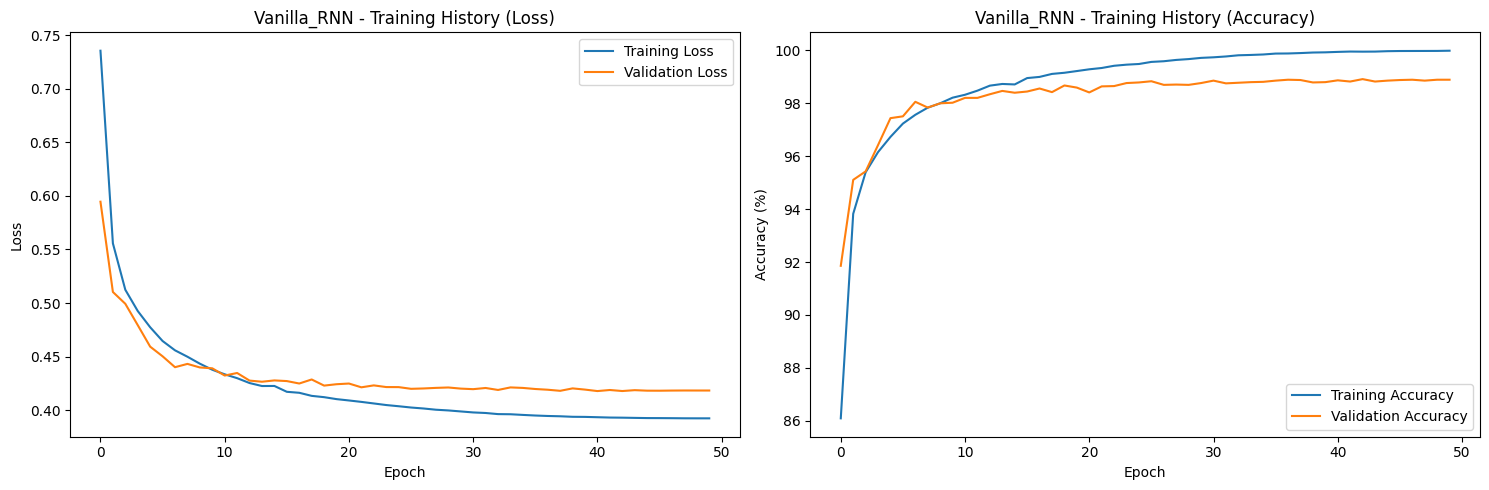

Testing: 100%|██████████| 685/685 [00:01<00:00, 370.68it/s]



Test Accuracy (Vanilla_RNN): 98.97%

Classification Report (Vanilla_RNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.94      0.83      0.88       556
           2       0.98      0.97      0.97      1448
           3       0.89      0.81      0.85       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.96      0.92      0.94     21892
weighted avg       0.99      0.99      0.99     21892



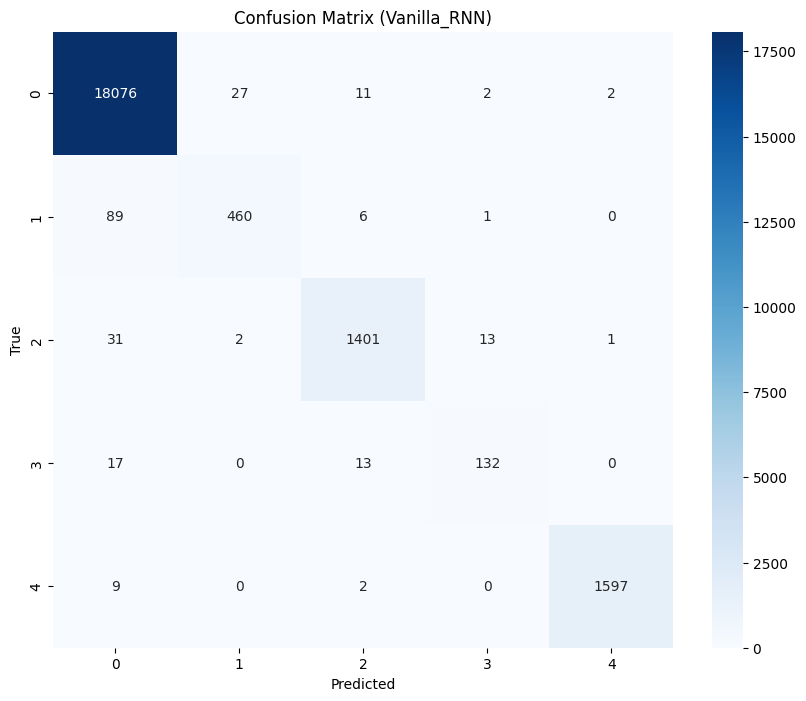

In [18]:
rnn_trainer, rnn_accuracy = train_rnn_model('Vanilla_RNN', train_loader, val_loader, test_loader)

C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)


Using device: cuda

Starting training for Vanilla_ConvBiGRU...


Training:   0%|          | 0/2657 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 2657/2657 [00:14<00:00, 187.21it/s]



Epoch [1/50]
Train Loss: 0.7041, Train Acc: 85.50%
Val   Loss: 0.5564, Val   Acc: 93.46%
Learning Rate: 0.000279
New best model saved! (Val Loss: 0.5564)


Training: 100%|██████████| 2657/2657 [00:13<00:00, 192.92it/s]



Epoch [2/50]
Train Loss: 0.5902, Train Acc: 91.06%
Val   Loss: 0.5117, Val   Acc: 95.20%
Learning Rate: 0.000616
New best model saved! (Val Loss: 0.5117)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 188.05it/s]



Epoch [3/50]
Train Loss: 0.5386, Train Acc: 93.61%
Val   Loss: 0.5349, Val   Acc: 93.57%
Learning Rate: 0.001034
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:13<00:00, 191.96it/s]



Epoch [4/50]
Train Loss: 0.5066, Train Acc: 95.15%
Val   Loss: 0.4751, Val   Acc: 97.05%
Learning Rate: 0.001371
New best model saved! (Val Loss: 0.4751)


Training: 100%|██████████| 2657/2657 [00:13<00:00, 190.61it/s]



Epoch [5/50]
Train Loss: 0.4830, Train Acc: 96.30%
Val   Loss: 0.4405, Val   Acc: 98.07%
Learning Rate: 0.001500
New best model saved! (Val Loss: 0.4405)


Training: 100%|██████████| 2657/2657 [00:13<00:00, 193.26it/s]



Epoch [6/50]
Train Loss: 0.4627, Train Acc: 97.24%
Val   Loss: 0.4574, Val   Acc: 96.97%
Learning Rate: 0.001498
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 189.67it/s]



Epoch [7/50]
Train Loss: 0.4522, Train Acc: 97.72%
Val   Loss: 0.4247, Val   Acc: 98.53%
Learning Rate: 0.001493
New best model saved! (Val Loss: 0.4247)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 182.22it/s]



Epoch [8/50]
Train Loss: 0.4446, Train Acc: 98.02%
Val   Loss: 0.4251, Val   Acc: 98.46%
Learning Rate: 0.001484
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 180.35it/s]



Epoch [9/50]
Train Loss: 0.4394, Train Acc: 98.23%
Val   Loss: 0.4450, Val   Acc: 97.52%
Learning Rate: 0.001471
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 179.68it/s]



Epoch [10/50]
Train Loss: 0.4373, Train Acc: 98.34%
Val   Loss: 0.4377, Val   Acc: 98.04%
Learning Rate: 0.001455
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 180.41it/s]



Epoch [11/50]
Train Loss: 0.4326, Train Acc: 98.51%
Val   Loss: 0.4281, Val   Acc: 98.39%
Learning Rate: 0.001435
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 180.67it/s]



Epoch [12/50]
Train Loss: 0.4319, Train Acc: 98.57%
Val   Loss: 0.4377, Val   Acc: 98.01%
Learning Rate: 0.001412
No improvement: 5/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 180.92it/s]



Epoch [13/50]
Train Loss: 0.4276, Train Acc: 98.74%
Val   Loss: 0.4245, Val   Acc: 98.49%
Learning Rate: 0.001386
New best model saved! (Val Loss: 0.4245)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 180.73it/s]



Epoch [14/50]
Train Loss: 0.4257, Train Acc: 98.86%
Val   Loss: 0.4279, Val   Acc: 98.30%
Learning Rate: 0.001357
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:15<00:00, 175.98it/s]



Epoch [15/50]
Train Loss: 0.4257, Train Acc: 98.84%
Val   Loss: 0.4295, Val   Acc: 98.30%
Learning Rate: 0.001325
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 184.64it/s]



Epoch [16/50]
Train Loss: 0.4236, Train Acc: 98.94%
Val   Loss: 0.4350, Val   Acc: 97.99%
Learning Rate: 0.001290
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.02it/s]



Epoch [17/50]
Train Loss: 0.4230, Train Acc: 98.94%
Val   Loss: 0.4229, Val   Acc: 98.60%
Learning Rate: 0.001252
New best model saved! (Val Loss: 0.4229)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 184.36it/s]



Epoch [18/50]
Train Loss: 0.4210, Train Acc: 99.03%
Val   Loss: 0.4259, Val   Acc: 98.44%
Learning Rate: 0.001212
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.82it/s]



Epoch [19/50]
Train Loss: 0.4204, Train Acc: 99.08%
Val   Loss: 0.4342, Val   Acc: 98.14%
Learning Rate: 0.001170
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 186.07it/s]



Epoch [20/50]
Train Loss: 0.4181, Train Acc: 99.13%
Val   Loss: 0.4330, Val   Acc: 98.08%
Learning Rate: 0.001125
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 186.32it/s]



Epoch [21/50]
Train Loss: 0.4169, Train Acc: 99.21%
Val   Loss: 0.4220, Val   Acc: 98.65%
Learning Rate: 0.001079
New best model saved! (Val Loss: 0.4220)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 182.71it/s]



Epoch [22/50]
Train Loss: 0.4157, Train Acc: 99.26%
Val   Loss: 0.4235, Val   Acc: 98.61%
Learning Rate: 0.001031
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.96it/s]



Epoch [23/50]
Train Loss: 0.4149, Train Acc: 99.27%
Val   Loss: 0.4198, Val   Acc: 98.84%
Learning Rate: 0.000982
New best model saved! (Val Loss: 0.4198)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 182.77it/s]



Epoch [24/50]
Train Loss: 0.4123, Train Acc: 99.40%
Val   Loss: 0.4233, Val   Acc: 98.66%
Learning Rate: 0.000932
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.60it/s]



Epoch [25/50]
Train Loss: 0.4118, Train Acc: 99.40%
Val   Loss: 0.4241, Val   Acc: 98.49%
Learning Rate: 0.000881
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.19it/s]



Epoch [26/50]
Train Loss: 0.4107, Train Acc: 99.44%
Val   Loss: 0.4208, Val   Acc: 98.69%
Learning Rate: 0.000829
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 186.04it/s]



Epoch [27/50]
Train Loss: 0.4087, Train Acc: 99.54%
Val   Loss: 0.4230, Val   Acc: 98.64%
Learning Rate: 0.000777
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 183.55it/s]



Epoch [28/50]
Train Loss: 0.4079, Train Acc: 99.58%
Val   Loss: 0.4239, Val   Acc: 98.62%
Learning Rate: 0.000725
No improvement: 5/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 186.90it/s]



Epoch [29/50]
Train Loss: 0.4072, Train Acc: 99.57%
Val   Loss: 0.4196, Val   Acc: 98.86%
Learning Rate: 0.000672
New best model saved! (Val Loss: 0.4196)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 182.62it/s]



Epoch [30/50]
Train Loss: 0.4057, Train Acc: 99.65%
Val   Loss: 0.4188, Val   Acc: 98.87%
Learning Rate: 0.000621
New best model saved! (Val Loss: 0.4188)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.50it/s]



Epoch [31/50]
Train Loss: 0.4041, Train Acc: 99.73%
Val   Loss: 0.4240, Val   Acc: 98.56%
Learning Rate: 0.000569
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 184.68it/s]



Epoch [32/50]
Train Loss: 0.4032, Train Acc: 99.76%
Val   Loss: 0.4225, Val   Acc: 98.63%
Learning Rate: 0.000519
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.53it/s]



Epoch [33/50]
Train Loss: 0.4019, Train Acc: 99.81%
Val   Loss: 0.4212, Val   Acc: 98.78%
Learning Rate: 0.000470
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 183.40it/s]



Epoch [34/50]
Train Loss: 0.4015, Train Acc: 99.82%
Val   Loss: 0.4216, Val   Acc: 98.81%
Learning Rate: 0.000422
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [00:15<00:00, 171.00it/s]



Epoch [35/50]
Train Loss: 0.4011, Train Acc: 99.83%
Val   Loss: 0.4186, Val   Acc: 98.93%
Learning Rate: 0.000376
New best model saved! (Val Loss: 0.4186)


Training: 100%|██████████| 2657/2657 [00:15<00:00, 167.48it/s]



Epoch [36/50]
Train Loss: 0.3997, Train Acc: 99.89%
Val   Loss: 0.4201, Val   Acc: 98.79%
Learning Rate: 0.000332
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 179.86it/s]



Epoch [37/50]
Train Loss: 0.3990, Train Acc: 99.92%
Val   Loss: 0.4198, Val   Acc: 98.85%
Learning Rate: 0.000289
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 180.40it/s]



Epoch [38/50]
Train Loss: 0.3988, Train Acc: 99.92%
Val   Loss: 0.4222, Val   Acc: 98.73%
Learning Rate: 0.000249
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 181.27it/s]



Epoch [39/50]
Train Loss: 0.3981, Train Acc: 99.94%
Val   Loss: 0.4197, Val   Acc: 98.80%
Learning Rate: 0.000212
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 182.58it/s]



Epoch [40/50]
Train Loss: 0.3976, Train Acc: 99.96%
Val   Loss: 0.4194, Val   Acc: 98.81%
Learning Rate: 0.000177
No improvement: 5/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 181.66it/s]



Epoch [41/50]
Train Loss: 0.3972, Train Acc: 99.97%
Val   Loss: 0.4188, Val   Acc: 98.88%
Learning Rate: 0.000145
No improvement: 6/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.03it/s]



Epoch [42/50]
Train Loss: 0.3970, Train Acc: 99.98%
Val   Loss: 0.4178, Val   Acc: 98.93%
Learning Rate: 0.000115
New best model saved! (Val Loss: 0.4178)


Training: 100%|██████████| 2657/2657 [00:14<00:00, 181.35it/s]



Epoch [43/50]
Train Loss: 0.3968, Train Acc: 99.98%
Val   Loss: 0.4186, Val   Acc: 98.95%
Learning Rate: 0.000089
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.25it/s]



Epoch [44/50]
Train Loss: 0.3967, Train Acc: 99.99%
Val   Loss: 0.4190, Val   Acc: 98.85%
Learning Rate: 0.000066
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 182.07it/s]



Epoch [45/50]
Train Loss: 0.3966, Train Acc: 99.99%
Val   Loss: 0.4191, Val   Acc: 98.82%
Learning Rate: 0.000047
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.12it/s]



Epoch [46/50]
Train Loss: 0.3965, Train Acc: 99.99%
Val   Loss: 0.4200, Val   Acc: 98.95%
Learning Rate: 0.000031
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 182.27it/s]



Epoch [47/50]
Train Loss: 0.3965, Train Acc: 99.99%
Val   Loss: 0.4194, Val   Acc: 98.88%
Learning Rate: 0.000018
No improvement: 5/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.65it/s]



Epoch [48/50]
Train Loss: 0.3965, Train Acc: 99.99%
Val   Loss: 0.4191, Val   Acc: 98.92%
Learning Rate: 0.000009
No improvement: 6/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 181.87it/s]



Epoch [49/50]
Train Loss: 0.3964, Train Acc: 99.99%
Val   Loss: 0.4193, Val   Acc: 98.87%
Learning Rate: 0.000003
No improvement: 7/10


Training: 100%|██████████| 2657/2657 [00:14<00:00, 185.42it/s]



Epoch [50/50]
Train Loss: 0.3964, Train Acc: 99.99%
Val   Loss: 0.4191, Val   Acc: 98.85%
Learning Rate: 0.000002
No improvement: 8/10


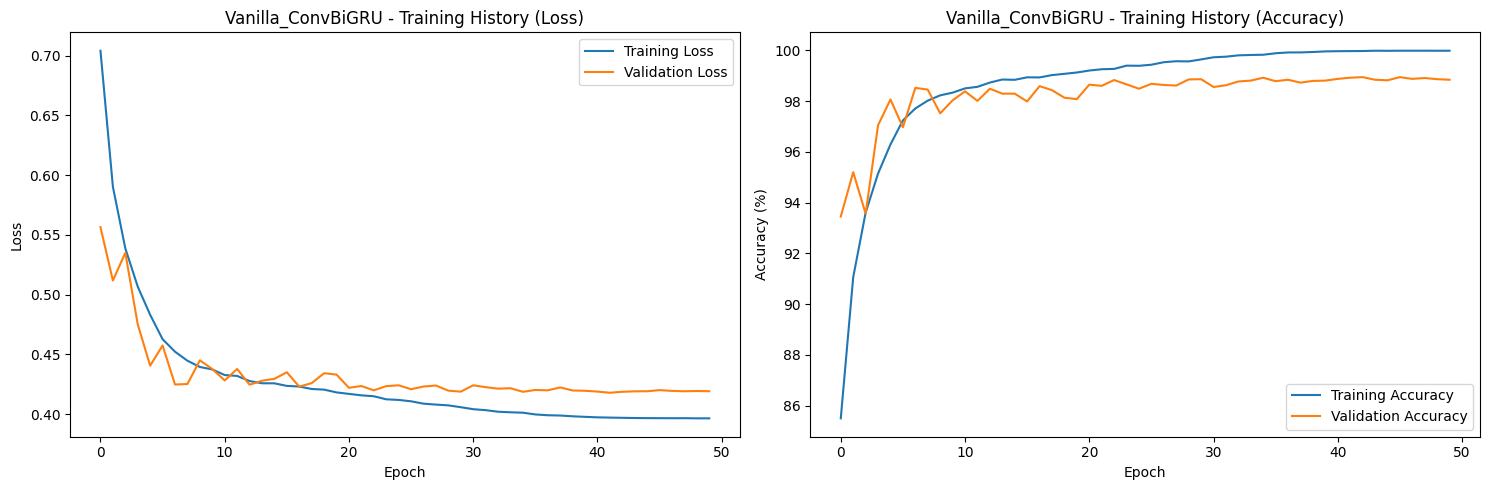

Testing: 100%|██████████| 685/685 [00:01<00:00, 569.46it/s]



Test Accuracy (Vanilla_ConvBiGRU): 98.55%

Classification Report (Vanilla_ConvBiGRU):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.83      0.86      0.84       556
           2       0.97      0.96      0.96      1448
           3       0.80      0.86      0.83       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.92      0.93      0.92     21892
weighted avg       0.99      0.99      0.99     21892



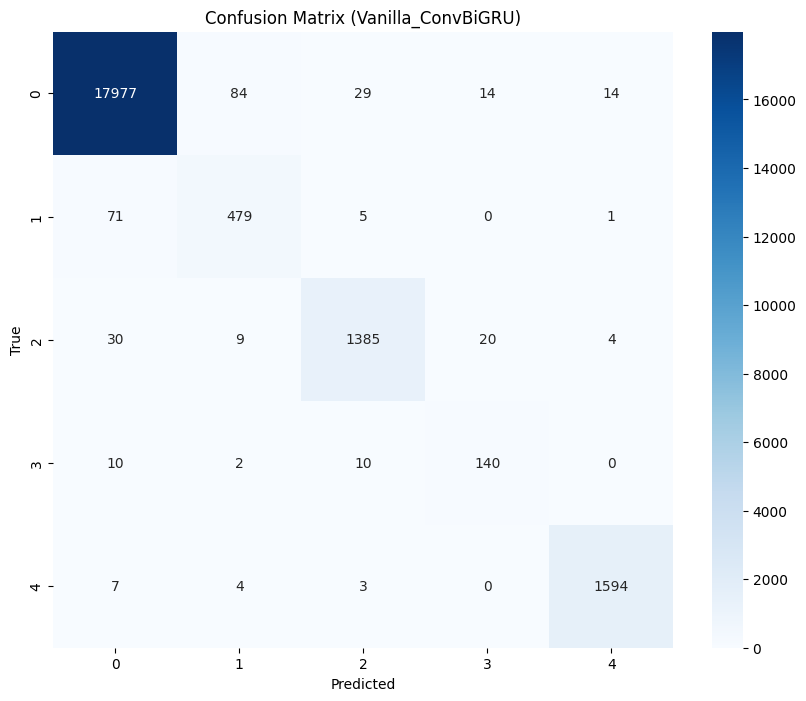

In [42]:
convbigru_trainer, convbigru_accuracy = train_conv_bigru_model('Vanilla_ConvBiGRU',train_loader, val_loader, test_loader)

In [20]:
print("Test Accuracies:")
print(f"RNN Model Test Accuracy: {rnn_accuracy*100:.2f}%")
print(f"ConvBiGRU Model Test Accuracy: {convbigru_accuracy*100:.2f}%")

Test Accuracies:
RNN Model Test Accuracy: 98.97%
ConvBiGRU Model Test Accuracy: 97.55%


## Data Preprocessing: Hybrid sampling strategy 
## (Under-sampling + SMOTE Over-sampling)

In [43]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

class NewECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train, X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name}:")
        classes = np.unique(y)
        for class_id in sorted(classes):
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"  Class {int(class_id)}: {count:6d} samples ({percentage:5.2f}%)")
        print(f"  Total: {len(y)} samples")

    def preprocess_mitbih_data(self):
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        # Split before applying sampling methods
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train
        )

        # Print Initial class distributions
        self._print_class_distribution("INITIAL Training Set ", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Step 1: Undersample Class 0 first
        undersample_strategy = {
            0: 40000  # Reduce Class 0 only
        }
        
        rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        
        # Step 2: Oversample minority classes with SMOTE
        oversample_strategy = {
            1: 15000,  
            2: 8000,    
            3: 12000,   
            4: 10000    
        }
        
        smote = SMOTE(sampling_strategy=oversample_strategy, random_state=42, k_neighbors=5)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Print final class distributions
        self._print_class_distribution("Training Set (after SMOTE + undersampling)", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Reshape
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        print(f"\nFinal dataset sizes:")
        print(f"Training set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Test set: {X_test.shape}")

        return X_train, X_val, X_test, y_train, y_val, y_test

In [44]:
# Create processor instance
processor = NewECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

Loading MIT-BIH dataset...

Class distribution in INITIAL Training Set :
  Class 0:  65223 samples (82.77%)
  Class 1:   2001 samples ( 2.54%)
  Class 2:   5209 samples ( 6.61%)
  Class 3:    577 samples ( 0.73%)
  Class 4:   5788 samples ( 7.35%)
  Total: 78798 samples

Class distribution in Validation Set:
  Class 0:   7248 samples (82.78%)
  Class 1:    222 samples ( 2.54%)
  Class 2:    579 samples ( 6.61%)
  Class 3:     64 samples ( 0.73%)
  Class 4:    643 samples ( 7.34%)
  Total: 8756 samples

Class distribution in Test Set:
  Class 0:  18118 samples (82.76%)
  Class 1:    556 samples ( 2.54%)
  Class 2:   1448 samples ( 6.61%)
  Class 3:    162 samples ( 0.74%)
  Class 4:   1608 samples ( 7.35%)
  Total: 21892 samples

Class distribution in Training Set (after SMOTE + undersampling):
  Class 0:  40000 samples (47.06%)
  Class 1:  15000 samples (17.65%)
  Class 2:   8000 samples ( 9.41%)
  Class 3:  12000 samples (14.12%)
  Class 4:  10000 samples (11.76%)
  Total: 85000 sampl

In [45]:
print("Final dataset shape:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Final dataset shape:
Training set: (85000, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


## Data Augmentation

To improve model robustness and generalization, we applied the following augmentation techniques using the `tsaug` library:

### Methods Applied

1. **Additive Gaussian Noise**
   - Simulates electronic and thermal interference in ECG equipment
   - Noise scale: 0.01
   - Probability: 60%

2. **Baseline Wander (Drift)**
   - Models low-frequency drift caused by patient respiration and movement
   - Maximum drift: 0.15
   - Drift points: 5
   - Probability: 50%

3. **Time Warping**
   - Simulates natural variations in heart rate and recording speed
   - Speed changes: 3
   - Maximum speed ratio: 1.5
   - Probability: 30%


1. Additive Noise (Gaussian):
    Applied: (85000, 187, 1)

2. Baseline Wander( Drift):
    Applied: (85000, 187, 1)

3. Time Warping:
    Applied: (85000, 187, 1)

4. Combined (Additive Noise + Baseline Wander + Time Warping) :
    Applied: (85000, 187, 1)

1. Plotting Additive Noise...


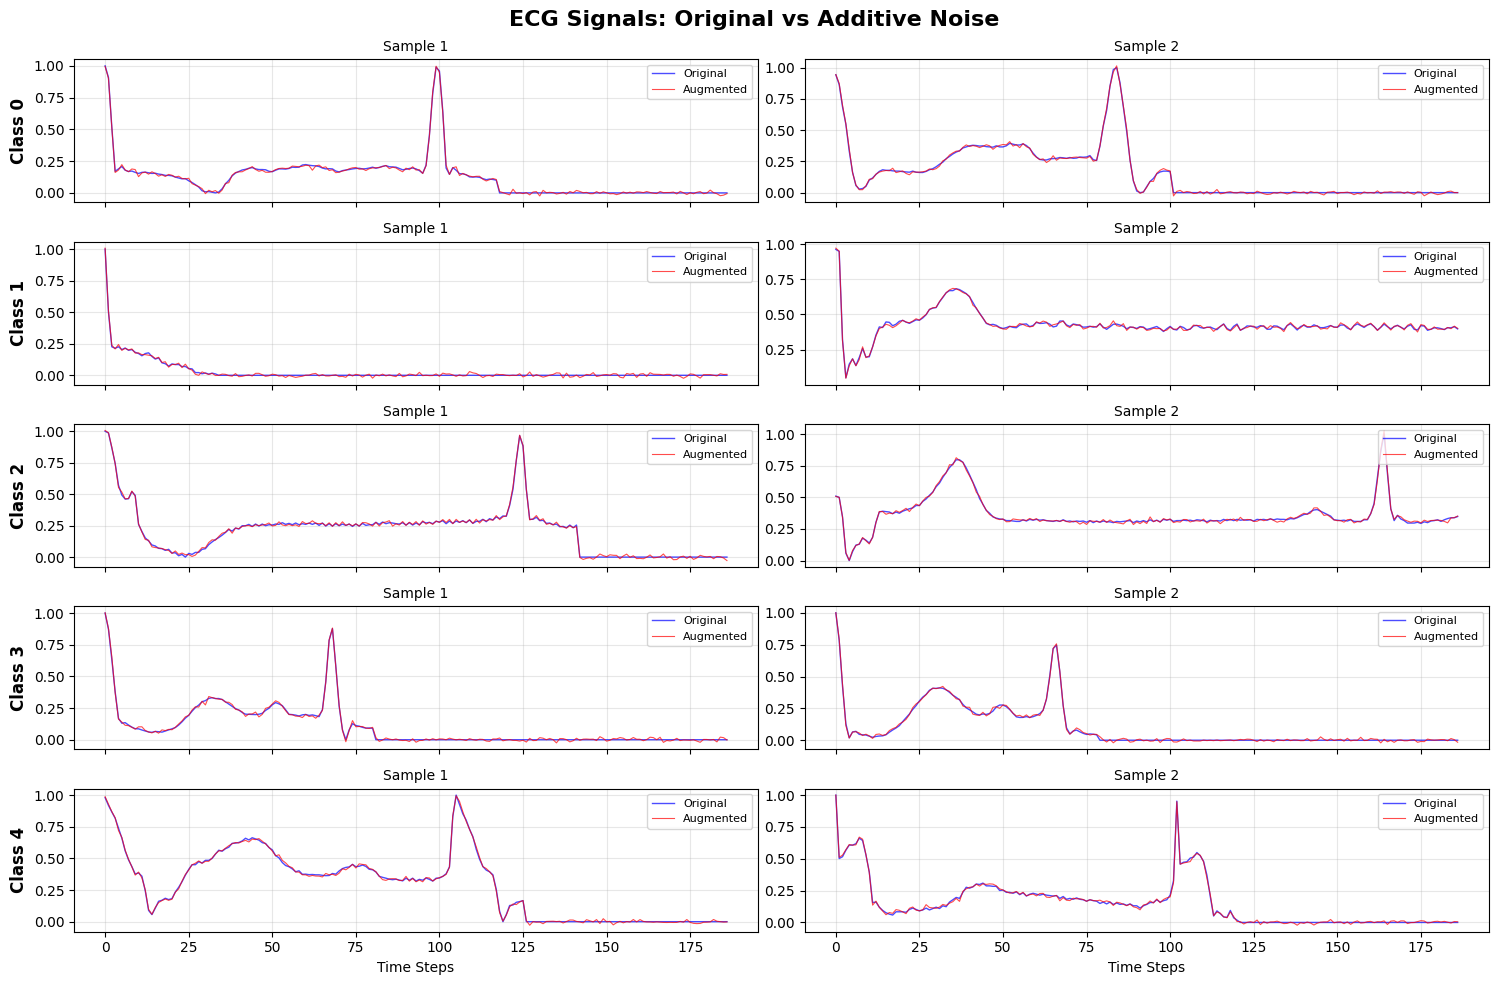


2. Plotting Baseline Wander...


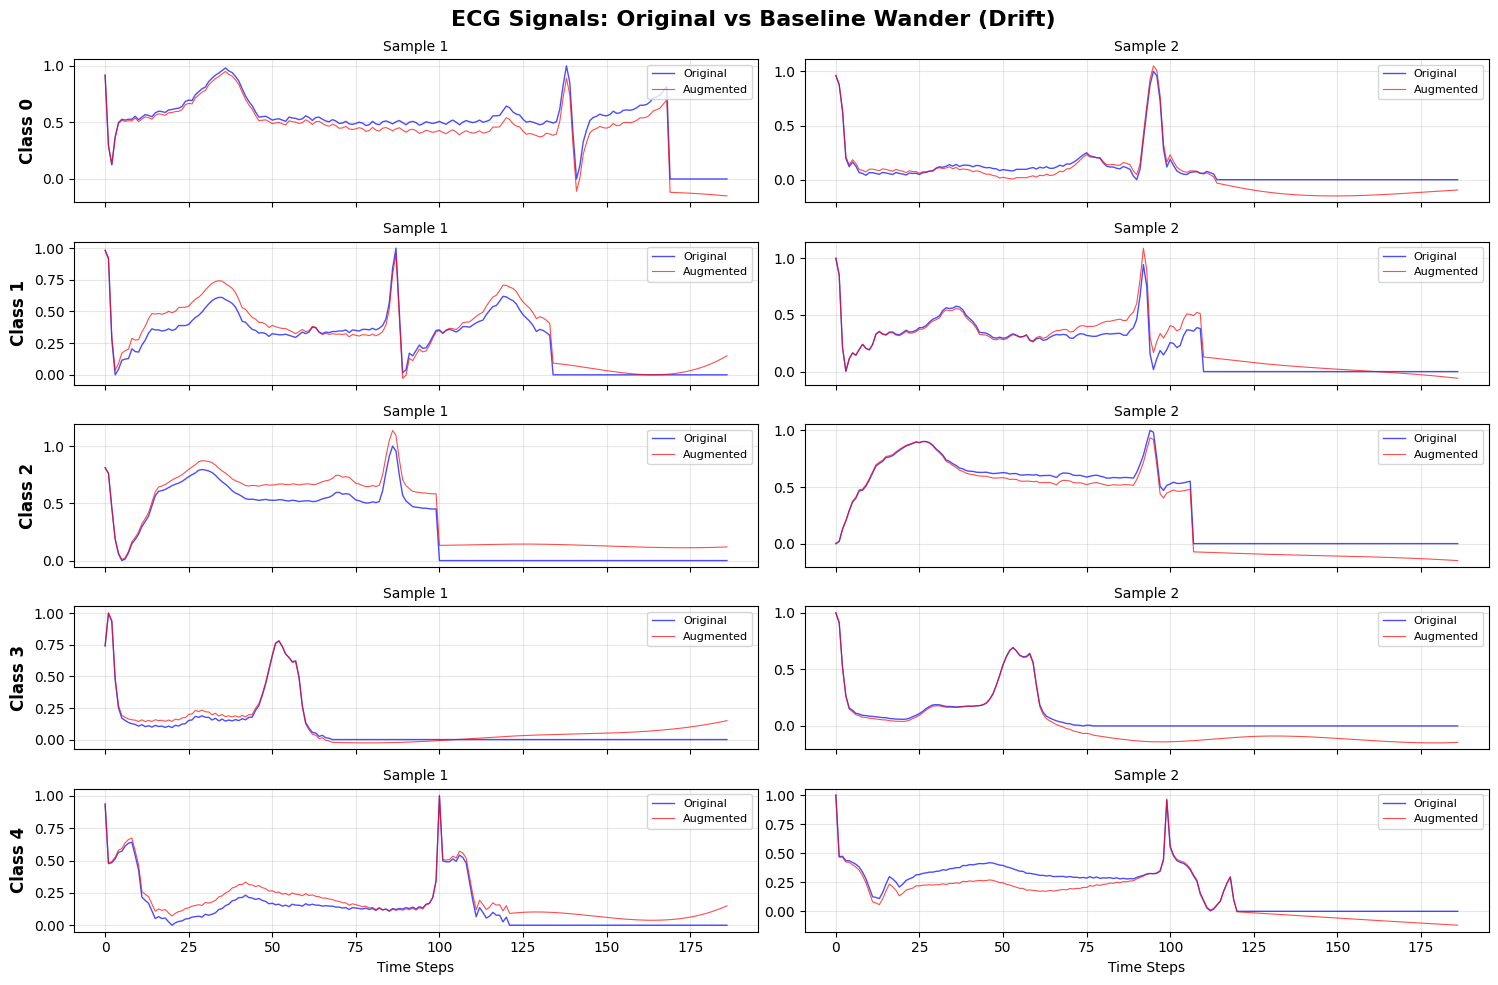


3. Plotting Time Warping...


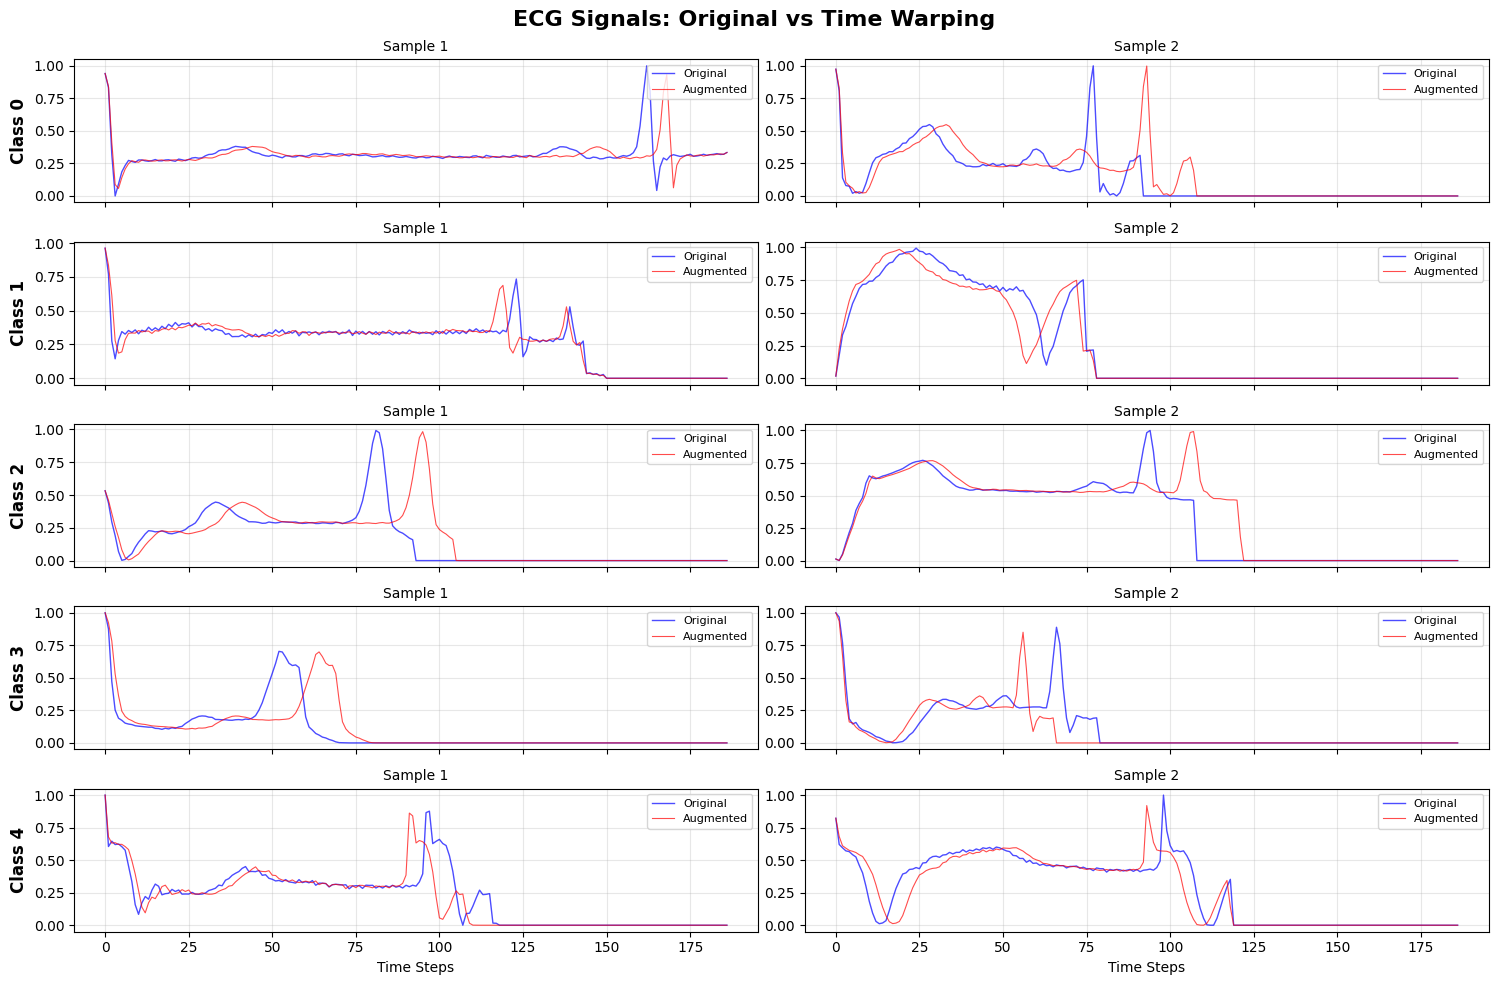


4. Plotting Combined Augmentation...


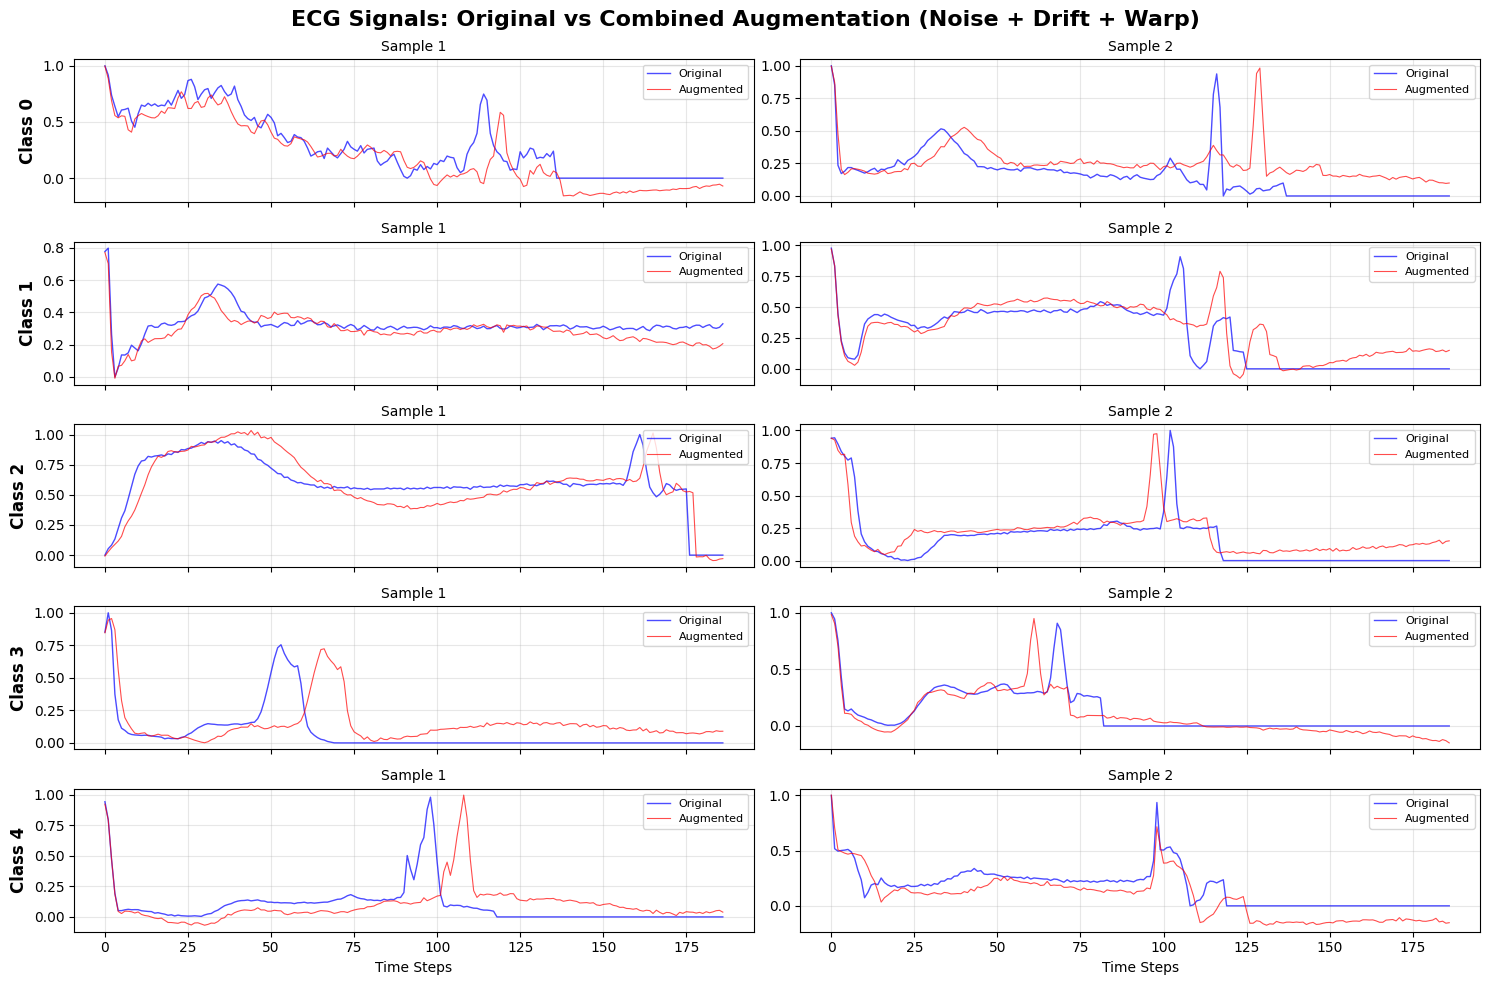

In [46]:
from tsaug import AddNoise, Drift, TimeWarp
import numpy as np
import matplotlib.pyplot as plt

# Define all augmentation methods
def apply_augmentations_separately(X_train):
    
    augmentations = {}
    
    # Additive Noise
    print("\n1. Additive Noise (Gaussian):")
    noise_augmenter = AddNoise(scale=0.01)
    augmentations['noise'] = noise_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['noise'].shape}")
    
    # Baseline Wander (Drift)
    print("\n2. Baseline Wander( Drift):")
    drift_augmenter = Drift(max_drift=0.15, n_drift_points=5)
    augmentations['drift'] = drift_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['drift'].shape}")
    
    # Time Warping
    print("\n3. Time Warping:")
    warp_augmenter = TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    augmentations['warp'] = warp_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['warp'].shape}")
    
    # Combined
    print("\n4. Combined (Additive Noise + Baseline Wander + Time Warping) :")
    combined_augmenter = (
        AddNoise(scale=0.01) +
        Drift(max_drift=0.15, n_drift_points=5) +
        TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    )
    augmentations['combined'] = combined_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['combined'].shape}")
    
    return augmentations


def plot_overlay_noise_comparison(X_original, X_noisy, y, samples_per_class=2, figsize=(15, 10), figtitle=""):
    """
    Plot original vs augmented signals overlaid
    """
    classes = np.unique(y)
    n_classes = len(classes)
    
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=figsize)
    
    # Set title
    if figtitle:
        fig.suptitle(figtitle, fontsize=16, fontweight='bold')
    else:
        fig.suptitle('ECG Signals: Original (Blue) vs Augmented (Red)', fontsize=16, fontweight='bold')
    
    # Handle single row or column
    if n_classes == 1 and samples_per_class == 1:
        axes = np.array([[axes]])
    elif n_classes == 1:
        axes = axes.reshape(1, -1)
    elif samples_per_class == 1:
        axes = axes.reshape(-1, 1)
    
    for i, class_id in enumerate(classes):
        # Get indices for this class
        class_indices = np.where(y == class_id)[0]
        
        # Randomly select samples
        selected_indices = np.random.choice(class_indices, 
                                           size=min(samples_per_class, len(class_indices)), 
                                           replace=False)
        
        for j, idx in enumerate(selected_indices):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            
            # Plot both signals overlaid
            signal_original = X_original[idx].squeeze()
            signal_noisy = X_noisy[idx].squeeze()
            
            ax.plot(signal_original, linewidth=1.0, color='blue', label='Original', alpha=0.7)
            ax.plot(signal_noisy, linewidth=0.8, color='red', label='Augmented', alpha=0.7)
            
            # Add class label on the left
            if j == 0:
                ax.set_ylabel(f'Class {int(class_id)}', fontsize=12, fontweight='bold')
            
            ax.set_title(f'Sample {j+1}', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=8)
            
            # Remove x-axis labels except for bottom row
            if i < n_classes - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Time Steps', fontsize=10)
    
    plt.tight_layout()
    plt.show()


augmentations = apply_augmentations_separately(X_train)

# 1. Additive Noise
print("\n1. Plotting Additive Noise...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['noise'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Additive Noise'
)

# 2. Baseline Wander
print("\n2. Plotting Baseline Wander...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['drift'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Baseline Wander (Drift)'
)

# 3. Time Warping
print("\n3. Plotting Time Warping...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['warp'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Time Warping'
)

# 4. Combined
print("\n4. Plotting Combined Augmentation...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['combined'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Combined Augmentation (Noise + Drift + Warp)'
)

In [47]:
class ECGDatasetAugmented(Dataset):
    """
    Custom Dataset class for ECG data with optional augmentation
    """
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
        
        if self.augment:
            self.augmenter = (
                AddNoise(scale=0.01) @ 0.6 +  # 60% probability
                Drift(max_drift=0.15, n_drift_points=5) @ 0.5 +  # 50% probability
                TimeWarp(n_speed_change=3, max_speed_ratio=1.5) @ 0.3  # 30% probability
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            x_numpy = x.numpy()
            x_aug = self.augmenter.augment(x_numpy.squeeze())
            x = torch.FloatTensor(x_aug.reshape(x_numpy.shape))
        
        return x, y


def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32, augment_train=True):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets - only augment training set
    train_dataset = ECGDatasetAugmented(X_train, y_train, augment=augment_train)
    val_dataset = ECGDatasetAugmented(X_val, y_val, augment=False)
    test_dataset = ECGDatasetAugmented(X_test, y_test, augment=False)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Print class distributions
    print("\n" + "="*60)
    print("DATA LOADERS CREATED")
    print("="*60)
    
    print(f"\nDataLoader Information:")
    print(f"  Training batches: {len(train_loader)} (batch_size={batch_size}, augment={augment_train})")
    print(f"  Validation batches: {len(val_loader)} (batch_size={batch_size})")
    print(f"  Test batches: {len(test_loader)} (batch_size={batch_size})")

    return train_loader, val_loader, test_loader


# Create data loaders WITH augmentation
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test, 
    batch_size=32, 
    augment_train=True 
)

# Print final dataset sizes
print("\n" + "="*60)
print("FINAL DATASET SHAPES")
print("="*60)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


DATA LOADERS CREATED

DataLoader Information:
  Training batches: 2657 (batch_size=32, augment=True)
  Validation batches: 274 (batch_size=32)
  Test batches: 685 (batch_size=32)

FINAL DATASET SHAPES
Training set: (85000, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [48]:
# Verify augmentation is actually happening
print("\n" + "="*60)
print("VERIFYING DYNAMIC AUGMENTATION")
print("="*60)

# Check the dataset class being used
print(f"Training dataset class: {type(train_loader.dataset).__name__}")
print(f"Augmentation enabled: {train_loader.dataset.augment}")

# Get two batches and see if they're different (proof of dynamic augmentation)
train_iter = iter(train_loader)
batch1_X, _ = next(train_iter)
batch1_X_first_sample = batch1_X[0].numpy()

# Reset and get same batch again (will be different due to dynamic augmentation)
train_iter = iter(train_loader)
batch2_X, _ = next(train_iter)
batch2_X_first_sample = batch2_X[0].numpy()

# They should be different due to augmentation
difference = np.abs(batch1_X_first_sample - batch2_X_first_sample).mean()
print(f"\nDifference between two fetches of same sample: {difference:.6f}")
if difference > 0:
    print(" Dynamic augmentation is WORKING (samples are different)")
else:
    print(" No augmentation (samples are identical)")


VERIFYING DYNAMIC AUGMENTATION
Training dataset class: ECGDatasetAugmented
Augmentation enabled: True

Difference between two fetches of same sample: 0.169474
 Dynamic augmentation is WORKING (samples are different)


C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)


Using device: cuda

Starting training for Augmented_RNN...


Training:   0%|          | 0/2657 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.35it/s]



Epoch [1/50]
Train Loss: 1.2393, Train Acc: 55.21%
Val   Loss: 0.8428, Val   Acc: 80.48%
Learning Rate: 0.000186
New best model saved! (Val Loss: 0.8428)


Training: 100%|██████████| 2657/2657 [01:31<00:00, 29.04it/s]



Epoch [2/50]
Train Loss: 0.9486, Train Acc: 72.48%
Val   Loss: 0.7443, Val   Acc: 87.08%
Learning Rate: 0.000411
New best model saved! (Val Loss: 0.7443)


Training: 100%|██████████| 2657/2657 [01:32<00:00, 28.75it/s]



Epoch [3/50]
Train Loss: 0.7973, Train Acc: 81.32%
Val   Loss: 0.6165, Val   Acc: 92.60%
Learning Rate: 0.000689
New best model saved! (Val Loss: 0.6165)


Training: 100%|██████████| 2657/2657 [01:35<00:00, 27.94it/s]



Epoch [4/50]
Train Loss: 0.6789, Train Acc: 87.11%
Val   Loss: 0.5329, Val   Acc: 94.66%
Learning Rate: 0.000914
New best model saved! (Val Loss: 0.5329)


Training: 100%|██████████| 2657/2657 [01:37<00:00, 27.17it/s]



Epoch [5/50]
Train Loss: 0.6154, Train Acc: 89.74%
Val   Loss: 0.4859, Val   Acc: 96.23%
Learning Rate: 0.001000
New best model saved! (Val Loss: 0.4859)


Training: 100%|██████████| 2657/2657 [01:33<00:00, 28.38it/s]



Epoch [6/50]
Train Loss: 0.5622, Train Acc: 92.44%
Val   Loss: 0.4713, Val   Acc: 96.63%
Learning Rate: 0.000999
New best model saved! (Val Loss: 0.4713)


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.47it/s]



Epoch [7/50]
Train Loss: 0.5284, Train Acc: 93.91%
Val   Loss: 0.4493, Val   Acc: 97.50%
Learning Rate: 0.000995
New best model saved! (Val Loss: 0.4493)


Training: 100%|██████████| 2657/2657 [01:31<00:00, 29.01it/s]



Epoch [8/50]
Train Loss: 0.5084, Train Acc: 94.85%
Val   Loss: 0.4807, Val   Acc: 95.80%
Learning Rate: 0.000989
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.74it/s]



Epoch [9/50]
Train Loss: 0.4916, Train Acc: 95.64%
Val   Loss: 0.4469, Val   Acc: 97.54%
Learning Rate: 0.000981
New best model saved! (Val Loss: 0.4469)


Training: 100%|██████████| 2657/2657 [01:27<00:00, 30.21it/s]



Epoch [10/50]
Train Loss: 0.4803, Train Acc: 96.18%
Val   Loss: 0.4692, Val   Acc: 96.39%
Learning Rate: 0.000970
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:26<00:00, 30.70it/s]



Epoch [11/50]
Train Loss: 0.4762, Train Acc: 96.37%
Val   Loss: 0.4422, Val   Acc: 97.60%
Learning Rate: 0.000957
New best model saved! (Val Loss: 0.4422)


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.38it/s]



Epoch [12/50]
Train Loss: 0.4644, Train Acc: 96.88%
Val   Loss: 0.4331, Val   Acc: 98.04%
Learning Rate: 0.000942
New best model saved! (Val Loss: 0.4331)


Training: 100%|██████████| 2657/2657 [01:31<00:00, 29.16it/s]



Epoch [13/50]
Train Loss: 0.4773, Train Acc: 96.31%
Val   Loss: 0.4511, Val   Acc: 96.98%
Learning Rate: 0.000924
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:31<00:00, 28.91it/s]



Epoch [14/50]
Train Loss: 0.4602, Train Acc: 97.12%
Val   Loss: 0.4411, Val   Acc: 97.57%
Learning Rate: 0.000905
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:31<00:00, 28.90it/s]



Epoch [15/50]
Train Loss: 0.4533, Train Acc: 97.39%
Val   Loss: 0.4409, Val   Acc: 97.73%
Learning Rate: 0.000883
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [01:33<00:00, 28.51it/s]



Epoch [16/50]
Train Loss: 0.4457, Train Acc: 97.74%
Val   Loss: 0.4254, Val   Acc: 98.47%
Learning Rate: 0.000860
New best model saved! (Val Loss: 0.4254)


Training: 100%|██████████| 2657/2657 [01:31<00:00, 28.95it/s]



Epoch [17/50]
Train Loss: 0.4423, Train Acc: 97.93%
Val   Loss: 0.4258, Val   Acc: 98.37%
Learning Rate: 0.000835
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:31<00:00, 29.06it/s]



Epoch [18/50]
Train Loss: 0.4390, Train Acc: 98.02%
Val   Loss: 0.4290, Val   Acc: 98.18%
Learning Rate: 0.000808
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:31<00:00, 28.92it/s]



Epoch [19/50]
Train Loss: 0.4364, Train Acc: 98.20%
Val   Loss: 0.4331, Val   Acc: 98.05%
Learning Rate: 0.000780
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [01:34<00:00, 28.08it/s]



Epoch [20/50]
Train Loss: 0.4330, Train Acc: 98.29%
Val   Loss: 0.4182, Val   Acc: 98.79%
Learning Rate: 0.000750
New best model saved! (Val Loss: 0.4182)


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.27it/s]



Epoch [21/50]
Train Loss: 0.4297, Train Acc: 98.46%
Val   Loss: 0.4207, Val   Acc: 98.72%
Learning Rate: 0.000719
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.30it/s]



Epoch [22/50]
Train Loss: 0.4263, Train Acc: 98.64%
Val   Loss: 0.4239, Val   Acc: 98.58%
Learning Rate: 0.000688
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.37it/s]



Epoch [23/50]
Train Loss: 0.4249, Train Acc: 98.68%
Val   Loss: 0.4216, Val   Acc: 98.58%
Learning Rate: 0.000655
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [01:33<00:00, 28.54it/s]



Epoch [24/50]
Train Loss: 0.4223, Train Acc: 98.83%
Val   Loss: 0.4300, Val   Acc: 98.21%
Learning Rate: 0.000621
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [01:35<00:00, 27.85it/s]



Epoch [25/50]
Train Loss: 0.4208, Train Acc: 98.85%
Val   Loss: 0.4211, Val   Acc: 98.64%
Learning Rate: 0.000587
No improvement: 5/10


Training: 100%|██████████| 2657/2657 [01:40<00:00, 26.32it/s]



Epoch [26/50]
Train Loss: 0.4192, Train Acc: 98.93%
Val   Loss: 0.4192, Val   Acc: 98.80%
Learning Rate: 0.000553
No improvement: 6/10


Training: 100%|██████████| 2657/2657 [01:32<00:00, 28.72it/s]



Epoch [27/50]
Train Loss: 0.4168, Train Acc: 99.03%
Val   Loss: 0.4288, Val   Acc: 98.40%
Learning Rate: 0.000518
No improvement: 7/10


Training: 100%|██████████| 2657/2657 [01:33<00:00, 28.39it/s]



Epoch [28/50]
Train Loss: 0.4157, Train Acc: 99.12%
Val   Loss: 0.4212, Val   Acc: 98.68%
Learning Rate: 0.000483
No improvement: 8/10


Training: 100%|██████████| 2657/2657 [01:32<00:00, 28.87it/s]



Epoch [29/50]
Train Loss: 0.4139, Train Acc: 99.20%
Val   Loss: 0.4213, Val   Acc: 98.64%
Learning Rate: 0.000448
No improvement: 9/10


Training: 100%|██████████| 2657/2657 [01:34<00:00, 28.00it/s]



Epoch [30/50]
Train Loss: 0.4117, Train Acc: 99.29%
Val   Loss: 0.4190, Val   Acc: 98.74%
Learning Rate: 0.000414
No improvement: 10/10
Early stopping triggered at epoch 30. Best val loss: 0.4182
Restored best model weights.


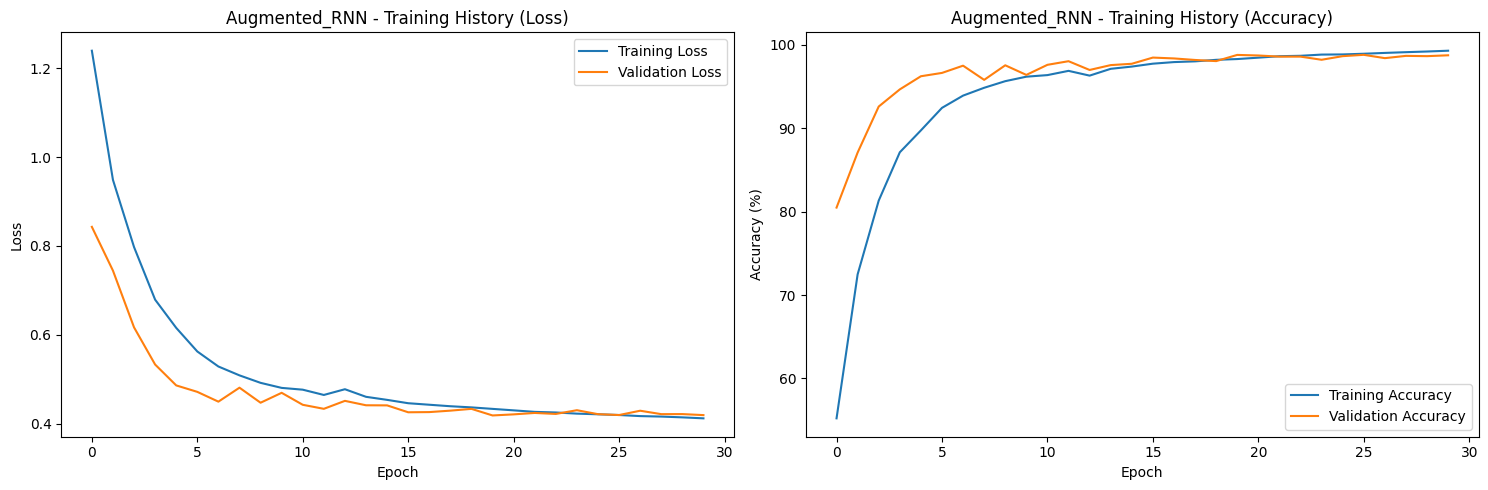

Testing: 100%|██████████| 685/685 [00:01<00:00, 371.91it/s]



Test Accuracy (Augmented_RNN): 98.45%

Classification Report (Augmented_RNN):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.86      0.82      0.84       556
           2       0.96      0.95      0.96      1448
           3       0.74      0.83      0.78       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.91      0.92      0.91     21892
weighted avg       0.98      0.98      0.98     21892



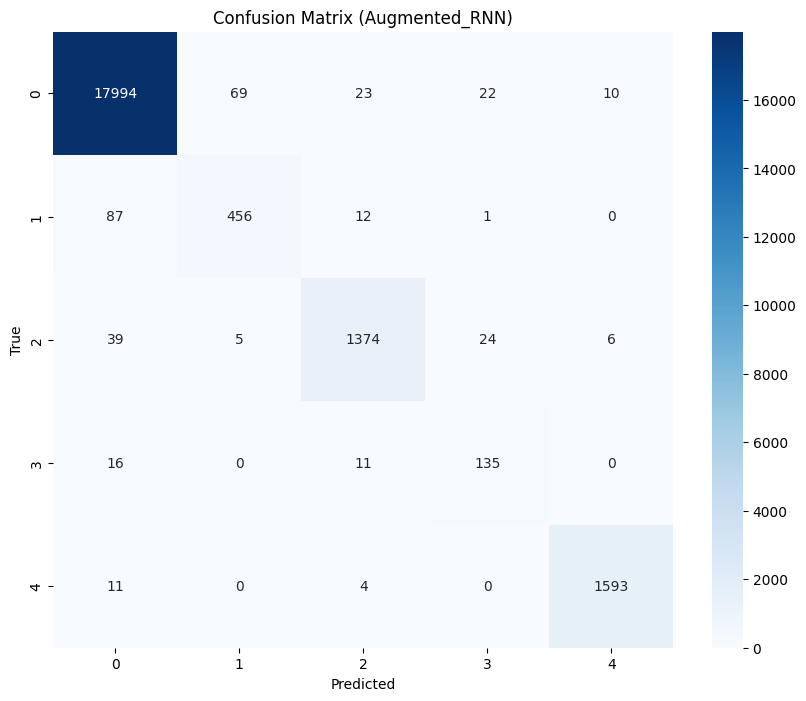

In [49]:
aug_rnn_trainer, aug_rnn_accuracy = train_rnn_model('Augmented_RNN', train_loader, val_loader, test_loader)

C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)


Using device: cuda

Starting training for Augmented_ConvBiGRU...


Training:   0%|          | 0/2657 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_20276\2364616059.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 2657/2657 [01:26<00:00, 30.87it/s]



Epoch [1/50]
Train Loss: 0.7667, Train Acc: 82.17%
Val   Loss: 0.5794, Val   Acc: 93.78%
Learning Rate: 0.000279
New best model saved! (Val Loss: 0.5794)


Training: 100%|██████████| 2657/2657 [01:27<00:00, 30.22it/s]



Epoch [2/50]
Train Loss: 0.6250, Train Acc: 89.36%
Val   Loss: 0.5256, Val   Acc: 94.95%
Learning Rate: 0.000616
New best model saved! (Val Loss: 0.5256)


Training: 100%|██████████| 2657/2657 [01:28<00:00, 29.97it/s]



Epoch [3/50]
Train Loss: 0.5576, Train Acc: 92.72%
Val   Loss: 0.4904, Val   Acc: 96.14%
Learning Rate: 0.001034
New best model saved! (Val Loss: 0.4904)


Training: 100%|██████████| 2657/2657 [01:27<00:00, 30.36it/s]



Epoch [4/50]
Train Loss: 0.5210, Train Acc: 94.65%
Val   Loss: 0.4561, Val   Acc: 97.52%
Learning Rate: 0.001371
New best model saved! (Val Loss: 0.4561)


Training: 100%|██████████| 2657/2657 [01:26<00:00, 30.60it/s]



Epoch [5/50]
Train Loss: 0.5022, Train Acc: 95.48%
Val   Loss: 0.4507, Val   Acc: 97.45%
Learning Rate: 0.001500
New best model saved! (Val Loss: 0.4507)


Training: 100%|██████████| 2657/2657 [01:28<00:00, 30.09it/s]



Epoch [6/50]
Train Loss: 0.4881, Train Acc: 96.03%
Val   Loss: 0.4502, Val   Acc: 97.75%
Learning Rate: 0.001498
New best model saved! (Val Loss: 0.4502)


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.68it/s]



Epoch [7/50]
Train Loss: 0.4746, Train Acc: 96.74%
Val   Loss: 0.4392, Val   Acc: 98.07%
Learning Rate: 0.001493
New best model saved! (Val Loss: 0.4392)


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.54it/s]



Epoch [8/50]
Train Loss: 0.4681, Train Acc: 97.03%
Val   Loss: 0.4543, Val   Acc: 97.30%
Learning Rate: 0.001484
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:28<00:00, 29.94it/s]



Epoch [9/50]
Train Loss: 0.4642, Train Acc: 97.16%
Val   Loss: 0.4297, Val   Acc: 98.48%
Learning Rate: 0.001471
New best model saved! (Val Loss: 0.4297)


Training: 100%|██████████| 2657/2657 [01:21<00:00, 32.74it/s]



Epoch [10/50]
Train Loss: 0.4605, Train Acc: 97.34%
Val   Loss: 0.4282, Val   Acc: 98.64%
Learning Rate: 0.001455
New best model saved! (Val Loss: 0.4282)


Training: 100%|██████████| 2657/2657 [01:21<00:00, 32.80it/s]



Epoch [11/50]
Train Loss: 0.4570, Train Acc: 97.46%
Val   Loss: 0.4307, Val   Acc: 98.37%
Learning Rate: 0.001435
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:24<00:00, 31.51it/s]



Epoch [12/50]
Train Loss: 0.4543, Train Acc: 97.56%
Val   Loss: 0.4346, Val   Acc: 98.05%
Learning Rate: 0.001412
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.69it/s]



Epoch [13/50]
Train Loss: 0.4529, Train Acc: 97.63%
Val   Loss: 0.4360, Val   Acc: 98.09%
Learning Rate: 0.001386
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [01:27<00:00, 30.44it/s]



Epoch [14/50]
Train Loss: 0.4504, Train Acc: 97.72%
Val   Loss: 0.4263, Val   Acc: 98.48%
Learning Rate: 0.001357
New best model saved! (Val Loss: 0.4263)


Training: 100%|██████████| 2657/2657 [01:20<00:00, 32.85it/s]



Epoch [15/50]
Train Loss: 0.4490, Train Acc: 97.79%
Val   Loss: 0.4323, Val   Acc: 98.20%
Learning Rate: 0.001325
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:20<00:00, 33.14it/s]



Epoch [16/50]
Train Loss: 0.4470, Train Acc: 97.93%
Val   Loss: 0.4223, Val   Acc: 98.65%
Learning Rate: 0.001290
New best model saved! (Val Loss: 0.4223)


Training: 100%|██████████| 2657/2657 [01:19<00:00, 33.22it/s]



Epoch [17/50]
Train Loss: 0.4455, Train Acc: 97.94%
Val   Loss: 0.4338, Val   Acc: 98.07%
Learning Rate: 0.001252
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:20<00:00, 33.11it/s]



Epoch [18/50]
Train Loss: 0.4431, Train Acc: 98.04%
Val   Loss: 0.4228, Val   Acc: 98.63%
Learning Rate: 0.001212
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:26<00:00, 30.83it/s]



Epoch [19/50]
Train Loss: 0.4424, Train Acc: 98.04%
Val   Loss: 0.4257, Val   Acc: 98.47%
Learning Rate: 0.001170
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [01:31<00:00, 29.05it/s]



Epoch [20/50]
Train Loss: 0.4424, Train Acc: 98.09%
Val   Loss: 0.4239, Val   Acc: 98.54%
Learning Rate: 0.001125
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.41it/s]



Epoch [21/50]
Train Loss: 0.4407, Train Acc: 98.15%
Val   Loss: 0.4250, Val   Acc: 98.46%
Learning Rate: 0.001079
No improvement: 5/10


Training: 100%|██████████| 2657/2657 [01:27<00:00, 30.54it/s]



Epoch [22/50]
Train Loss: 0.4388, Train Acc: 98.24%
Val   Loss: 0.4259, Val   Acc: 98.39%
Learning Rate: 0.001031
No improvement: 6/10


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.61it/s]



Epoch [23/50]
Train Loss: 0.4370, Train Acc: 98.32%
Val   Loss: 0.4263, Val   Acc: 98.44%
Learning Rate: 0.000982
No improvement: 7/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.27it/s]



Epoch [24/50]
Train Loss: 0.4347, Train Acc: 98.40%
Val   Loss: 0.4311, Val   Acc: 98.12%
Learning Rate: 0.000932
No improvement: 8/10


Training: 100%|██████████| 2657/2657 [01:27<00:00, 30.26it/s]



Epoch [25/50]
Train Loss: 0.4330, Train Acc: 98.50%
Val   Loss: 0.4214, Val   Acc: 98.64%
Learning Rate: 0.000881
New best model saved! (Val Loss: 0.4214)


Training: 100%|██████████| 2657/2657 [01:28<00:00, 30.04it/s]



Epoch [26/50]
Train Loss: 0.4314, Train Acc: 98.53%
Val   Loss: 0.4217, Val   Acc: 98.48%
Learning Rate: 0.000829
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.21it/s]



Epoch [27/50]
Train Loss: 0.4290, Train Acc: 98.62%
Val   Loss: 0.4224, Val   Acc: 98.49%
Learning Rate: 0.000777
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.60it/s]



Epoch [28/50]
Train Loss: 0.4286, Train Acc: 98.64%
Val   Loss: 0.4207, Val   Acc: 98.71%
Learning Rate: 0.000725
New best model saved! (Val Loss: 0.4207)


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.51it/s]



Epoch [29/50]
Train Loss: 0.4272, Train Acc: 98.69%
Val   Loss: 0.4210, Val   Acc: 98.64%
Learning Rate: 0.000672
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:28<00:00, 29.91it/s]



Epoch [30/50]
Train Loss: 0.4255, Train Acc: 98.79%
Val   Loss: 0.4234, Val   Acc: 98.50%
Learning Rate: 0.000621
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:31<00:00, 28.93it/s]



Epoch [31/50]
Train Loss: 0.4248, Train Acc: 98.84%
Val   Loss: 0.4208, Val   Acc: 98.61%
Learning Rate: 0.000569
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.48it/s]



Epoch [32/50]
Train Loss: 0.4220, Train Acc: 98.98%
Val   Loss: 0.4199, Val   Acc: 98.74%
Learning Rate: 0.000519
New best model saved! (Val Loss: 0.4199)


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.48it/s]



Epoch [33/50]
Train Loss: 0.4203, Train Acc: 99.03%
Val   Loss: 0.4180, Val   Acc: 98.73%
Learning Rate: 0.000470
New best model saved! (Val Loss: 0.4180)


Training: 100%|██████████| 2657/2657 [01:31<00:00, 29.14it/s]



Epoch [34/50]
Train Loss: 0.4193, Train Acc: 99.05%
Val   Loss: 0.4176, Val   Acc: 98.72%
Learning Rate: 0.000422
New best model saved! (Val Loss: 0.4176)


Training: 100%|██████████| 2657/2657 [01:33<00:00, 28.41it/s]



Epoch [35/50]
Train Loss: 0.4175, Train Acc: 99.16%
Val   Loss: 0.4200, Val   Acc: 98.61%
Learning Rate: 0.000376
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.26it/s]



Epoch [36/50]
Train Loss: 0.4168, Train Acc: 99.16%
Val   Loss: 0.4203, Val   Acc: 98.66%
Learning Rate: 0.000332
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:31<00:00, 29.04it/s]



Epoch [37/50]
Train Loss: 0.4150, Train Acc: 99.23%
Val   Loss: 0.4158, Val   Acc: 98.88%
Learning Rate: 0.000289
New best model saved! (Val Loss: 0.4158)


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.71it/s]



Epoch [38/50]
Train Loss: 0.4144, Train Acc: 99.31%
Val   Loss: 0.4170, Val   Acc: 98.78%
Learning Rate: 0.000249
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.58it/s]



Epoch [39/50]
Train Loss: 0.4127, Train Acc: 99.38%
Val   Loss: 0.4159, Val   Acc: 98.78%
Learning Rate: 0.000212
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:28<00:00, 29.98it/s]



Epoch [40/50]
Train Loss: 0.4123, Train Acc: 99.35%
Val   Loss: 0.4153, Val   Acc: 98.80%
Learning Rate: 0.000177
New best model saved! (Val Loss: 0.4153)


Training: 100%|██████████| 2657/2657 [01:28<00:00, 30.00it/s]



Epoch [41/50]
Train Loss: 0.4107, Train Acc: 99.42%
Val   Loss: 0.4154, Val   Acc: 98.79%
Learning Rate: 0.000145
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:28<00:00, 29.98it/s]



Epoch [42/50]
Train Loss: 0.4102, Train Acc: 99.47%
Val   Loss: 0.4152, Val   Acc: 98.84%
Learning Rate: 0.000115
New best model saved! (Val Loss: 0.4152)


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.76it/s]



Epoch [43/50]
Train Loss: 0.4098, Train Acc: 99.46%
Val   Loss: 0.4162, Val   Acc: 98.85%
Learning Rate: 0.000089
No improvement: 1/10


Training: 100%|██████████| 2657/2657 [01:29<00:00, 29.68it/s]



Epoch [44/50]
Train Loss: 0.4085, Train Acc: 99.52%
Val   Loss: 0.4165, Val   Acc: 98.72%
Learning Rate: 0.000066
No improvement: 2/10


Training: 100%|██████████| 2657/2657 [01:30<00:00, 29.52it/s]



Epoch [45/50]
Train Loss: 0.4090, Train Acc: 99.50%
Val   Loss: 0.4157, Val   Acc: 98.80%
Learning Rate: 0.000047
No improvement: 3/10


Training: 100%|██████████| 2657/2657 [01:27<00:00, 30.52it/s]



Epoch [46/50]
Train Loss: 0.4083, Train Acc: 99.53%
Val   Loss: 0.4160, Val   Acc: 98.79%
Learning Rate: 0.000031
No improvement: 4/10


Training: 100%|██████████| 2657/2657 [01:20<00:00, 33.02it/s]



Epoch [47/50]
Train Loss: 0.4083, Train Acc: 99.53%
Val   Loss: 0.4159, Val   Acc: 98.77%
Learning Rate: 0.000018
No improvement: 5/10


Training: 100%|██████████| 2657/2657 [01:21<00:00, 32.75it/s]



Epoch [48/50]
Train Loss: 0.4082, Train Acc: 99.54%
Val   Loss: 0.4157, Val   Acc: 98.77%
Learning Rate: 0.000009
No improvement: 6/10


Training: 100%|██████████| 2657/2657 [01:24<00:00, 31.32it/s]



Epoch [49/50]
Train Loss: 0.4082, Train Acc: 99.53%
Val   Loss: 0.4154, Val   Acc: 98.81%
Learning Rate: 0.000003
No improvement: 7/10


Training: 100%|██████████| 2657/2657 [01:32<00:00, 28.57it/s]



Epoch [50/50]
Train Loss: 0.4079, Train Acc: 99.55%
Val   Loss: 0.4151, Val   Acc: 98.85%
Learning Rate: 0.000002
No improvement: 8/10


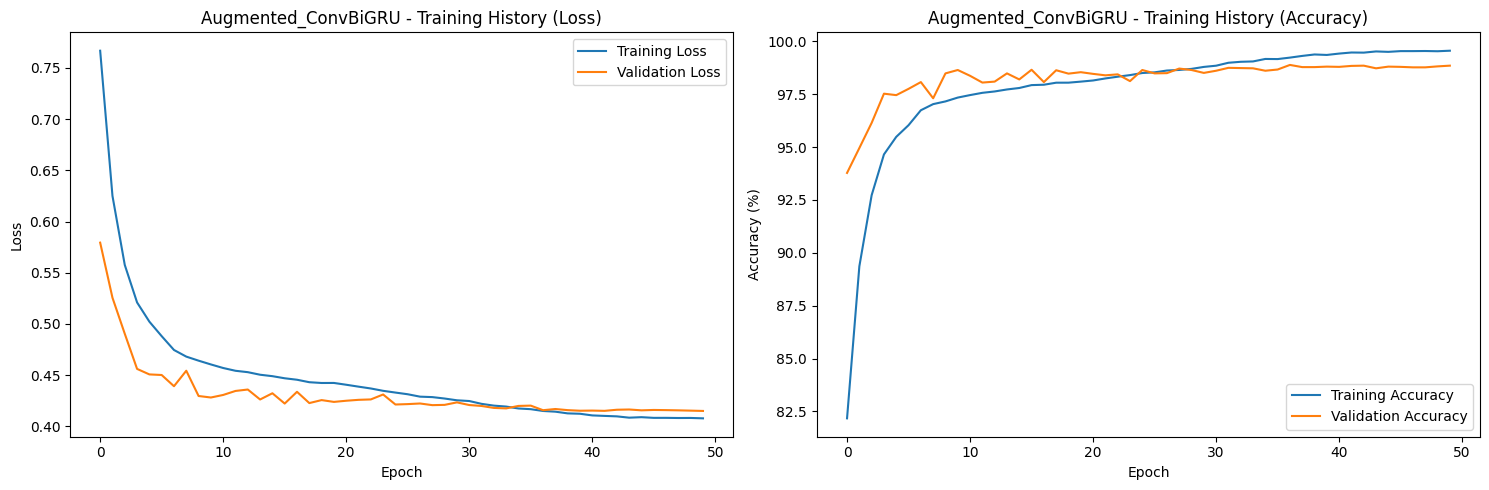

Testing: 100%|██████████| 685/685 [00:01<00:00, 559.24it/s]



Test Accuracy (Augmented_ConvBiGRU): 98.83%

Classification Report (Augmented_ConvBiGRU):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.86      0.87      0.87       556
           2       0.97      0.96      0.97      1448
           3       0.82      0.88      0.85       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.93      0.94      0.93     21892
weighted avg       0.99      0.99      0.99     21892



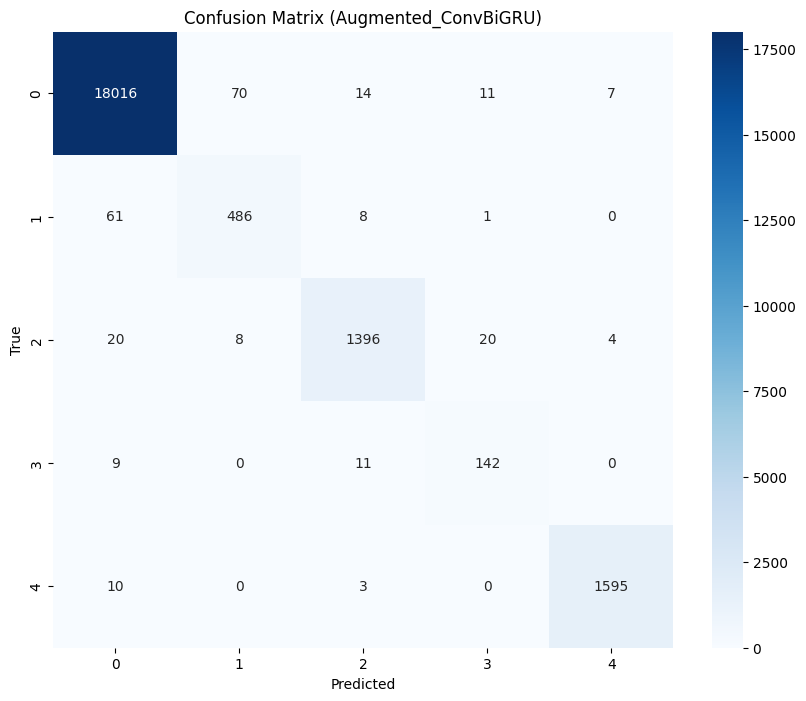

In [50]:
aug_convbigru_trainer, aug_convbigru_accuracy = train_conv_bigru_model('Augmented_ConvBiGRU',train_loader, val_loader, test_loader)

In [55]:
print("Test Accuracies:")
print(f"Augmented RNN Model Test Accuracy: {aug_rnn_accuracy*100:.2f}%")
print(f"Augmented ConvBiGRU Model Test Accuracy: {aug_convbigru_accuracy*100:.2f}%")

Test Accuracies:
Augmented RNN Model Test Accuracy: 98.45%
Augmented ConvBiGRU Model Test Accuracy: 98.83%
